<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression or any other suitable classifier.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [3]:
import requests
import bs4
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
import requests
import sys
import threading
from timeit import Timer
import seaborn as sns

In [68]:
from scipy.stats import scoreatpercentile

In [4]:
plt.style.use('bmh')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl",3))

In [5]:
r = requests.get(URL)
soup = BeautifulSoup(r.text, 'html.parser')

In [6]:
soup

<!DOCTYPE html>

<html dir="ltr" lang="en">
<head>
<meta content="text/html;charset=utf-8" http-equiv="content-type"/>
<script src="/s/52a3c6c/en_US.js" type="text/javascript"></script>
<link href="/s/970d98c/jobsearch_all.css" rel="stylesheet" type="text/css"/>
<link href="http://rss.indeed.com/rss?q=data+scientist+%2420%2C000&amp;l=New+York" rel="alternate" title="Data Scientist $20,000 Jobs, Employment in New York State" type="application/rss+xml"/>
<link href="/m/jobs?q=data+scientist+%2420%2C000&amp;l=New+York" media="only screen and (max-width: 640px)" rel="alternate"/>
<link href="/m/jobs?q=data+scientist+%2420%2C000&amp;l=New+York" media="handheld" rel="alternate"/>
<script type="text/javascript">
    
    if (typeof window['closureReadyCallbacks'] == 'undefined') {
        window['closureReadyCallbacks'] = [];
    }

    function call_when_jsall_loaded(cb) {
        if (window['closureReady']) {
            cb();
        } else {
            window['closureReadyCallbacks'].pus

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [7]:
## YOUR CODE HERE
def extract_location(i):
    
    try:
        return i.find('span', attrs={'class':'location'}).text.strip()
    except:
        try:
            return i.find('div', attrs={'class':'location'}).text.strip()

        except:
            return np.nan

def extract_company(i):
    try:
        return i.find('span', attrs={'class':'company'}).text.strip()
    except:
        return np.nan
    
def extract_job(i):
    try:
        return i.find('h2', attrs={'class':'jobtitle'}).text.strip()
    except:
        try:
            return i.find('a', attrs={'class':'jobtitle'}).text.strip()
        except:
            return np.nan
    
def extract_salary(i):
    try:
        return i.find('span', attrs={'class':'no-wrap'}).text.strip()
    except:
        return np.nan
    
def extract_link(i):

    try:
        return 'https://www.indeed.com'+ i.find('a', attrs={'class':'turnstileLink'})['href']
    except:
        return np.nan
def extract_summary(i):
    try:
        return i.find('span', attrs={'class':'summary'}).text.strip()
    
    except:
        return np.nan

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

In [8]:
YOUR_CITY = 'London'

In [9]:
t_ = requests.get('http://www.ukcities.co.uk/')
uk_cities = BeautifulSoup(t_.text, 'html.parser')
uk_city_list = [city.text for city in uk_cities.find_all('li') if 'cities' not in city.text][5:-9]
uk_city_list= [x.replace('City of ',"")for x in uk_city_list]

In [10]:
uk_city_list[:5]

['Bath', 'Birmingham', 'Bradford', 'Brighton and Hove', 'Bristol']

In [11]:
url_template = "http://www.indeed{}/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

city_list =['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 'Los+Angeles', 'Philadelphia', 
            'Atlanta', 'Dallas', 'Pittsburgh', 'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami','Raleigh',
            'Boston','San+Diego','Dallas','Hartford','Atlanta','St. Louis',
            'Toronto','Washington+DC','Silicon+Valley']+ uk_city_list

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [12]:
url = 'https://www.indeed{}/jobs?q=data+scientist+%C2%A3{}%2C000+-+%C2%A3{}%2C000&l={}&start={}'

In [13]:
def request_item(url,salary, city, page ,return_dict):

    try:
        if city in uk_city_list:
            url_code= '.co.uk'
        else:
            url_code= '.com'
        # make request for that page
        r = requests.get(url.format(url_code,str(salary),str(salary+10),city,page))
    
    except requests.RequestException:
        return None
    
    # Store the HTML
    if r.status_code !=404:
        k = city+"_"+str(page)+"_"+str(salary)+"-"+str(salary+10)
        return_dict[k] = r.text

In [14]:
#Test out the request item function on a single city

bath_dict={}
request_item(url,10,'Bath',10, bath_dict)

In [15]:
bath_dict;

In [16]:
def max_sal_results(city, url_code,salary):
    """determines the maximum number of results to iterate over"""
    url='https://www.indeed{}/jobs?q=data+scientist+%C2%A3{}%2C000+-+%C2%A3{}%2C000&l={}'.format(url_code,str(salary),str(salary+10),city)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    try:
        max_results_per_city_sal=int(soup.find('div', attrs={'id':"searchCount"}).text.strip().split(' ')[-2].replace(',',''))
    except:
        max_results_per_city_sal=1
    return max_results_per_city_sal

In [17]:
#Check if the max sal range function is working
max_sal_results('Chicago','.com',40)

26

In [18]:
def get_exchange_rate():
    """Strips the USD/GBP exchange rate from yahoo finance"""
    exchange_url = 'https://finance.yahoo.com/quote/GBPUSD=X/?guccounter=1'
    e = requests.get(exchange_url) 
    soup = BeautifulSoup(e.text,'html.parser')   
    exchange_rate = float(soup.find('span', attrs={'class':"Trsdu(0.3s)"}).text)
    
    return exchange_rate

In [19]:
get_exchange_rate()

1.28115

In [20]:
def request_concurrent(url, request_item=request_item):
    """Requests a specific bunch of items from indeed IN PARALLEL

    Parameters
    ---------
    index_min: the lowest index to be parsed in the url 
    index_max: the highest index to be parsed in the url

    Returns
    -------
    return_dict: the dictionary containing the web scraping results
    """
    sys.stdout.write("Requesting in parallel...\n")

    manager = mp.Manager()
    return_dict = manager.dict()
    threads = []
    
    for city in tqdm_notebook(city_list):  
        if city in uk_city_list:
            url_code= '.co.uk'
        else:
            url_code= '.com'
        
        for salary in tqdm_notebook(range(20,200,10)):
            
            for page in range(0, (max_sal_results(city,url_code,salary)+10), 10):
            # thread calls the function request_item with the 

            # the name serves as an id for the current thread
                thread = threading.Thread(name=city+"_"+ str(page)+'_'+str(salary), 
                                      target=request_item, 
                                      args=(url,salary, city, page ,return_dict))
                thread.start()
                threads.append(thread)

    for t in threads:
        t.join()
    
    print("Waiting for threads to finish execution.")
    return return_dict

In [21]:
indeed_dict = request_concurrent(url, request_item=request_item)

Requesting in parallel...


ConnectionError: HTTPSConnectionPool(host='www.indeed.co.uk', port=443): Max retries exceeded with url: /jobs?q=data+scientist+%C2%A340%2C000+-+%C2%A350%2C000&l=Cambridge (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x108485240>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known',))

In [ ]:
len(indeed_dict.keys())

In [ ]:
def indeed_scrapper_new(scrapped_dict):
    """Takes the scrapped webpage dictionary and parses the information into a dictionary"""    
    location = []
    salary = []
    job = []
    link = []
    company = []
    city_ = []
    summary = []
    for key,value in scrapped_dict.items():
            soup = BeautifulSoup(value, 'html.parser')
            for i in soup.find_all('div', attrs={'class':'jobsearch-SerpJobCard'}):
                location.append(extract_location(i))
                link.append(extract_link(i))
                job.append(extract_job(i))
                salary.append(extract_salary(i))
                company.append(extract_company(i))
                city_.append(key.split('_')[0])
                summary.append(extract_summary(i))
    job_df = pd.DataFrame({
                            'City':city_,                    
                            'Job':job,
                            'Location':location,
                            'Company':company,
                            'Salary':salary,
                            'Link':link
                           
                          })
    job_df.to_csv('indeed_job_data_25_12_17',index=False)
    return job_df 

In [ ]:
job_df = indeed_scrapper_new(indeed_dict)

In [22]:
job_df = pd.read_csv('../project-4/indeed_job_data_25_12_17',index_col=0)

In [23]:
job_df.shape

(40983, 6)

In [24]:
job_df.head()

City                                         Job            Location  \
0  New+York           Data Operations & Research Intern        New York, NY   
1  New+York                            Analytics Intern         Buffalo, NY   
2  New+York                       Laboratory Technician      Brookhaven, NY   
3  New+York  Graduate Student Science/Policy Internship        New York, NY   
4  New+York                 Research Intern Spring 2019  Brooklyn, NY 11201   

                                         Company       Salary  \
0                                       CompStak          NaN   
1                                 Delaware North  $12 an hour   
2                         Amneal Pharmaceuticals          NaN   
3  New York State Office of the Attorney General          NaN   
4                                   Kindness.org          NaN   

                                                Link  
0  https://www.indeed.com/rc/clk?jk=e2b1a650ff6bc...  
1  https://www.indeed.com/rc/clk?jk=c305726f214da...  
2  https://www.indeed.com/rc/clk?jk=cc1fffd31ceef...  
3  https://www.indeed.com/rc/clk?jk=596b56e8a7aa8...  
4  https://www.indeed.com/rc/clk?jk=738c573fe717f...

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

In [25]:
job_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40983 entries, 0 to 40982
Data columns (total 6 columns):
City        40983 non-null object
Job         40983 non-null object
Location    40983 non-null object
Company     40980 non-null object
Salary      9324 non-null object
Link        40983 non-null object
dtypes: object(6)
memory usage: 2.2+ MB


In [26]:
job_df.head()

City                                         Job            Location  \
0  New+York           Data Operations & Research Intern        New York, NY   
1  New+York                            Analytics Intern         Buffalo, NY   
2  New+York                       Laboratory Technician      Brookhaven, NY   
3  New+York  Graduate Student Science/Policy Internship        New York, NY   
4  New+York                 Research Intern Spring 2019  Brooklyn, NY 11201   

                                         Company       Salary  \
0                                       CompStak          NaN   
1                                 Delaware North  $12 an hour   
2                         Amneal Pharmaceuticals          NaN   
3  New York State Office of the Attorney General          NaN   
4                                   Kindness.org          NaN   

                                                Link  
0  https://www.indeed.com/rc/clk?jk=e2b1a650ff6bc...  
1  https://www.indeed.com/rc/clk?jk=c305726f214da...  
2  https://www.indeed.com/rc/clk?jk=cc1fffd31ceef...  
3  https://www.indeed.com/rc/clk?jk=596b56e8a7aa8...  
4  https://www.indeed.com/rc/clk?jk=738c573fe717f...

In [27]:
job_df.dropna(subset=['Salary','Job'],inplace=True)

In [28]:
def make_clickable(val):
    return '<a target="_blank" href={}">{}</a>'.format(val,val)

def click(job_df):

    return job_df.style.format({'Link':make_clickable})

In [29]:
job_df.head()

City                                                Job  \
1   New+York                                   Analytics Intern   
7   New+York                                   Analytics Intern   
12  New+York   School Survey Data Collector -New York, New York   
14  New+York  Research Assistant, World Trade Center Health ...   
15  New+York  IT Services Support Assistant - IT Support Ass...   

         Location                                      Company  \
1     Buffalo, NY                               Delaware North   
7     Buffalo, NY                               Delaware North   
12   New York, NY                                          ICF   
14  Manhattan, NY  New York City DEPT OF HEALTH/MENTAL HYGIENE   
15   New York, NY       The City University of New York (CUNY)   

                     Salary                                               Link  
1               $12 an hour  https://www.indeed.com/rc/clk?jk=c305726f214da...  
7               $12 an hour  https://www.indeed.com/rc/clk?jk=c305726f214da...  
12              $720 a week  https://www.indeed.com/rc/clk?jk=1718b1ff80382...  
14  $13.50 - $17.90 an hour  https://www.indeed.com/rc/clk?jk=8fefcd3008995...  
15           $19.68 an hour  https://www.indeed.com/rc/clk?jk=dc4aeaabb8ba5...

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

In [30]:
job_df=job_df.loc[job_df['Salary'].isin(list(filter(lambda x: 'year' in x , job_df.Salary)))]

In [31]:
job_df.drop_duplicates(subset=['Location','Job', 'Company','Salary'],inplace=True)

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [32]:
job_df.reset_index(inplace=True,drop=True)

In [33]:
## YOUR CODE HERE
def usd_salary_string_to_float(data,exchange_rate):
    """Function strips the text and then converts the salaries to floats. if there are two values then the
    mean of the two salaries is taken. the salary is converted to $USD if originally from UK"""

    salaries = [i.replace('-','').replace(',','').replace('£',"").replace('$',"").strip().split() 
                for i in data['Salary']]
    salaries = pd.DataFrame(salaries,columns=['lower','upper','year','','','']).replace('a',np.nan)[['lower','upper']]
    salaries['lower']=pd.to_numeric(salaries['lower'])
    salaries['upper']=pd.to_numeric(salaries['upper'])

    average_salaries=[np.mean(row) if row['upper']==np.nan else row['lower']  
                      for index, row in salaries.iterrows()]
    exchange_rate=get_exchange_rate()
    salaries_convert=[round(row*exchange_rate) if data.iloc[i][0] in uk_city_list else round(row,0) 
                      for i,row in enumerate(average_salaries)]
    cities = [i.replace('+'," ") for i in data['City']]
    data.drop(columns=['Salary','City'],inplace=True)
    data['Salary_USD']=salaries_convert
    data['City']=cities
    
    
    return data

In [34]:
job_df = usd_salary_string_to_float(job_df,get_exchange_rate())

In [35]:
#Clean up the city by taking the location only if it appears anywhere in the city_search column, 
#otherwise the search_city is taken.

loc_rev=[]
for i, city in job_df.Location.iteritems():
    if city in list(job_df.City.unique()):
        loc_rev.append(city)
    else :
        loc_rev.append(job_df.City[i])
job_df['City_clean']=loc_rev

In [36]:
job_df.columns

Index(['Job', 'Location', 'Company', 'Link', 'Salary_USD', 'City',
       'City_clean'],
      dtype='object')

In [37]:
#Reorder the job_df columns for better reading
job_df=job_df[['Job','Location','City_clean', 'Salary_USD','Company', 'Link']]

In [38]:
job_df.shape

(2102, 6)

In [39]:
job_df.head()

Job      Location City_clean  \
0             Senior Research Staff Assistant  New York, NY   New York   
1                  Associate Research Analyst  New York, NY   New York   
2  Sr Analyst, Data Management Quant Analysis  Syracuse, NY   New York   
3             Postdoctoral Associate (R18-05)    Albany, NY   New York   
4                        Research Scientist I    Albany, NY   New York   

   Salary_USD                       Company  \
0     45000.0           Columbia University   
1     40000.0              Harrington Starr   
2     45000.0                    BNY Mellon   
3     38000.0  Research Foundation for SUNY   
4     56326.0  Health Research Incorporated   

                                                Link  
0  https://www.indeed.com/rc/clk?jk=5def350ae6574...  
1  https://www.indeed.com/company/Harrington-Star...  
2  https://www.indeed.com/company/BNY-Mellon/jobs...  
3  https://www.indeed.com/rc/clk?jk=289e4a090399b...  
4  https://www.indeed.com/rc/clk?jk=f243890119947...

In [40]:
#drop cities where the job count is less than 5
job_df = job_df[job_df.groupby('City_clean')['City_clean'].transform(len) > 4]
job_df.reset_index(inplace=True)

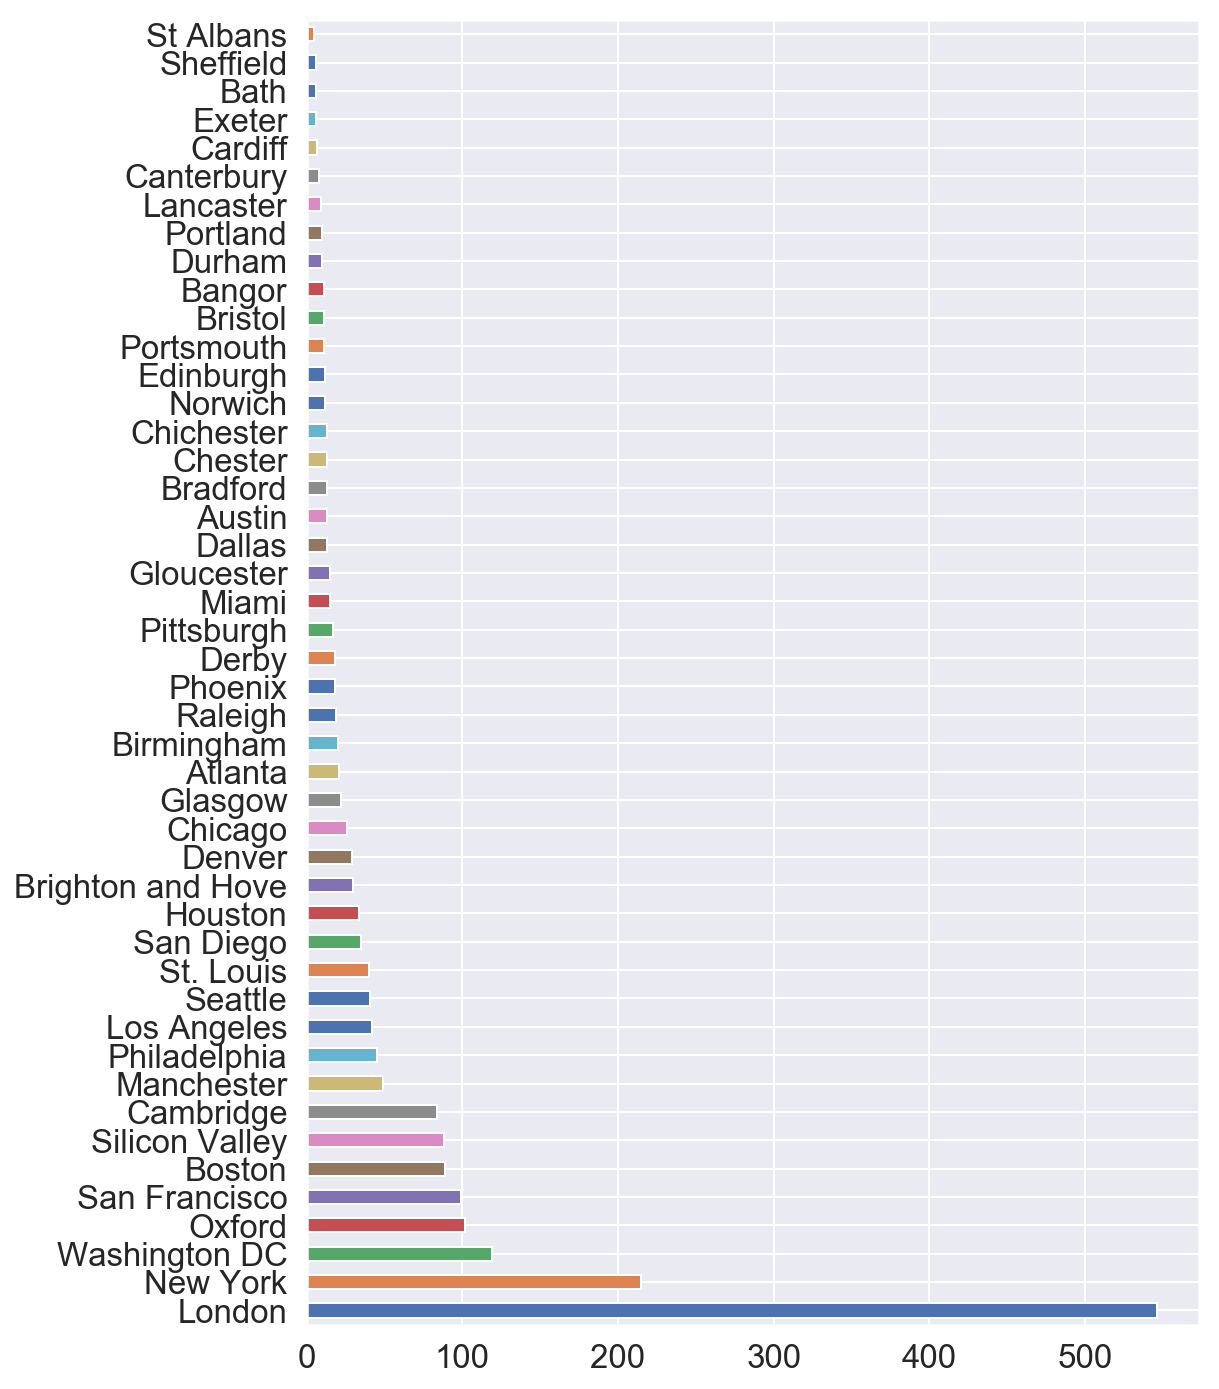

In [41]:
counts = job_df.City_clean.value_counts()
counts.plot(kind='barh',figsize=(8,12));

### Save your results as a CSV

In [42]:
## YOUR CODE HERE
job_df.to_csv('indeed_job_data_25_11_17_clean',index=False)

## QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your model's performance.

#### Load in the the data of scraped salaries

In [65]:
## YOUR CODE HERE
job_df = pd.read_csv('./indeed_job_data_25_11_17_clean',index_col='index')

In [66]:
job_df.head()

Job      Location City_clean  \
index                                                                        
0                 Senior Research Staff Assistant  New York, NY   New York   
1                      Associate Research Analyst  New York, NY   New York   
2      Sr Analyst, Data Management Quant Analysis  Syracuse, NY   New York   
3                 Postdoctoral Associate (R18-05)    Albany, NY   New York   
4                            Research Scientist I    Albany, NY   New York   

       Salary_USD                       Company  \
index                                             
0         45000.0           Columbia University   
1         40000.0              Harrington Starr   
2         45000.0                    BNY Mellon   
3         38000.0  Research Foundation for SUNY   
4         56326.0  Health Research Incorporated   

                                                    Link  
index                                                     
0      https://www.indeed.com/rc/clk?jk=5def350ae6574...  
1      https://www.indeed.com/company/Harrington-Star...  
2      https://www.indeed.com/company/BNY-Mellon/jobs...  
3      https://www.indeed.com/rc/clk?jk=289e4a090399b...  
4      https://www.indeed.com/rc/clk?jk=f243890119947...

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [69]:
med_sal = np.median(job_df.Salary_USD)
job_df['sal_bin']=[1 if row['Salary_USD']>med_sal else 0 for i,row in job_df.iterrows()]
#add in a column for a 70% threshold
percentile = 70
job_df['sal_thresh_70']=[1 if row['Salary_USD']>scoreatpercentile(job_df.Salary_USD, percentile) else 0 for i,row in job_df.iterrows()]
print ('Median salary for the scrapped jobs:\t',med_sal)
std_sal =np.std(job_df.Salary_USD)
print('standard deviation of the salaries:\t',int(std_sal))

Median salary for the scrapped jobs:	 72552.0
standard deviation of the salaries:	 34105


In [70]:
job_df

Job  \
index                                                      
0                        Senior Research Staff Assistant   
1                             Associate Research Analyst   
2             Sr Analyst, Data Management Quant Analysis   
3                        Postdoctoral Associate (R18-05)   
4                                   Research Scientist I   
5                                Analyst | Data Analysis   
6               Program Analytics /Data Analysis Manager   
7                                             Accountant   
8            Postdoctoral Researcher in Machine Learning   
9      Provider and Jurisdictional Liaison, Bureau of...   
10                 Analyst, Market Research and Strategy   
11            Ultrasound Scientist / Biomedical Engineer   
12                       Junior Data Integration Analyst   
13                          Assistant Research Scientist   
14                                  Research Scientist I   
15                             Junior Integration Tester   
16     Field Research Associate, Bureau of Alcohol an...   
17     Evaluation Coordinator, New York City Teens Co...   
18     Postdoctoral Research Scientist in Biomedical ...   
19     Program Coordinator, Healthy Living by Design,...   
20                  Inventory Product Manager - Cannabis   
21     Postdoctoral Research Scientist in Computation...   
22     Data Manager, Bureau of Maternal Infant and Re...   
23              POLICY and OPERSTIONS RESEARCH | ANALYST   
24                   Research Scientist 1 / EOA# 2018-62   
25     Data Analyst, Bureau of Clinical Quality Manag...   
26     Technical Assistance Specialist, Bureau of Alc...   
27                                     Real Estate Agent   
28                                Energy Program Analyst   
29                                           GIS Analyst   
...                                                  ...   
2071                                           Scientist   
2072                                Laboratory Scientist   
2073        Senior Assistant Scientist (Maternity Cover)   
2074                                      Data Scientist   
2075                                     Research Fellow   
2076                                     Project Manager   
2077                               Senior Data Scientist   
2078   Principal Researcher - Statistical Genomics & ...   
2079                                      Data Scientist   
2080                                       Data Engineer   
2081                                      Data Scientist   
2082                         Q-Step Centre Administrator   
2083                                      Data Scientist   
2084                              Scientist - Immunology   
2085                              Asset Services Manager   
2086                    Senior Buyer - Assets & Services   
2087        Research Associate in Plant Health Modelling   
2088                                      Data Scientist   
2089                      A2 Principal MI Data Scientist   
2090                                      Data Scientist   
2091                                      Data Scientist   
2092                        Lecturer in Machine Learning   
2093                                     Project Manager   
2094                   Clinician in Small Animal Surgery   
2095                            Clinical Research Fellow   
2096   Professor/Senior Clinician in Veterinary Oncology   
2097                                      Data Scientist   
2098                                    UI/Data Engineer   
2099   Senior Clinician/Clinician in Small Animal Onc...   
2100   Senior Clinician/Clinician in Small Animal Sof...   

                                           Location City_clean  Salary_USD  \
index                                                                        
0                                      New York, NY   New York     45000.0   
1                                     

In [71]:
job_df.sal_bin.value_counts()

0    1035
1    1032
Name: sal_bin, dtype: int64

#### Thought experiment: What is the baseline accuracy for this model?

In [72]:
med_sal

72552.0

### Create a classification model to predict High/Low salary. 


#### Model based on location:

- Start by ONLY using the location as a feature. 
- Use logistic regression with both statsmodels and sklearn.
- Use a further classifier you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.

#### Model taking into account job levels and categories:

- Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title or whether 'Manager' is in the title. 
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value? 
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models. 
- Discuss model coefficients or feature importances as applicable.

#### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. 


- Use cross-validation to evaluate your models. 
- Evaluate the accuracy, AUC, precision and recall of the models. 
- Plot the ROC and precision-recall curves for at least one of your models.

## Model based on Salary only

In [73]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split
import seaborn as sns
import matplotlib.text as t

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

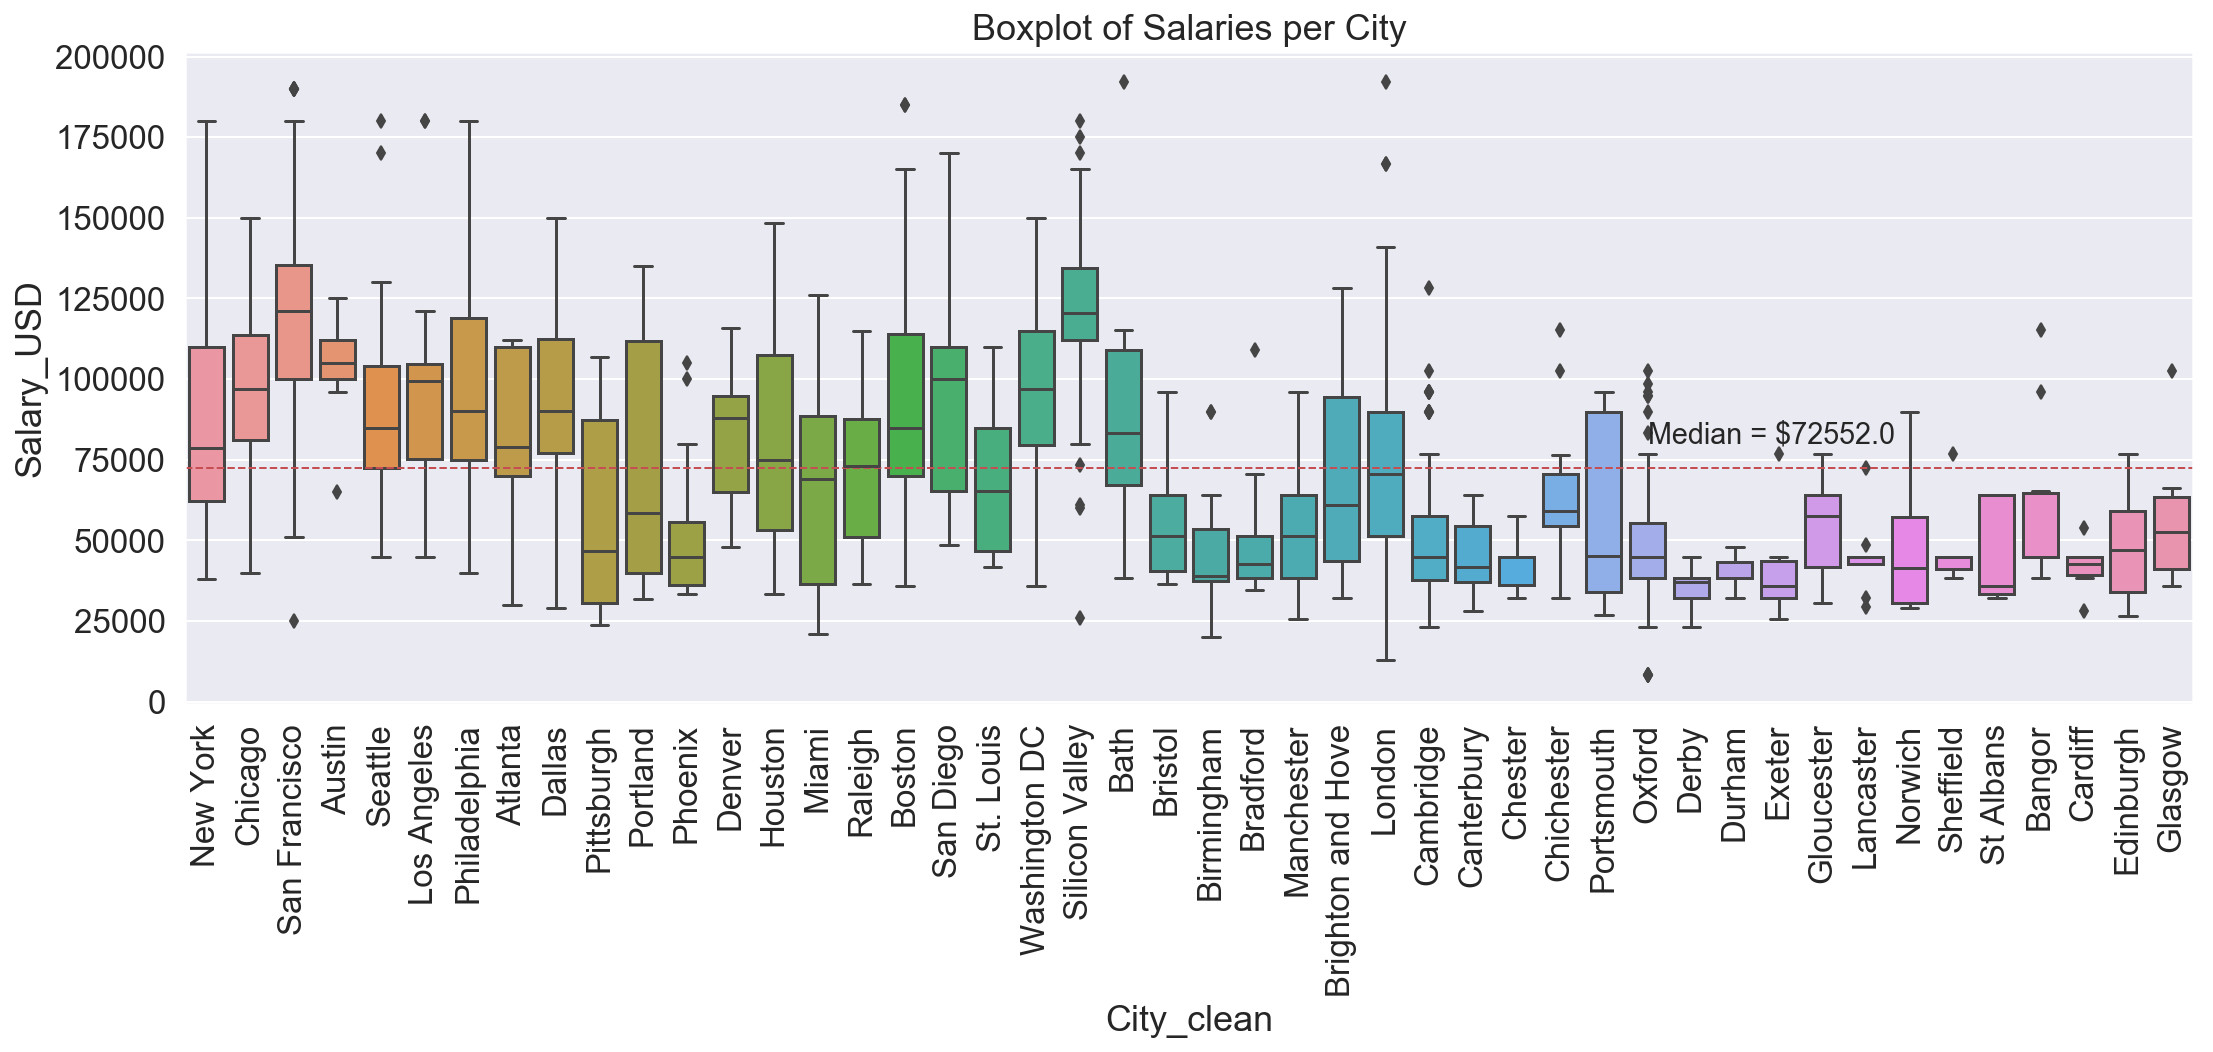

In [75]:
fig, ax = plt.subplots( figsize=(18, 6))
ax.set(title='Boxplot of Salaries per City')
plt.xticks(rotation=90) 
ax = sns.boxplot(x='City_clean',y='Salary_USD',data = job_df, ax=ax,)
plt.axhline(med_sal, linewidth=1, color='r',label='median',linestyle='--')
plt.text(33,80000,'Median = $'+str(round(med_sal,0)),fontsize='x-large')
plt.show()

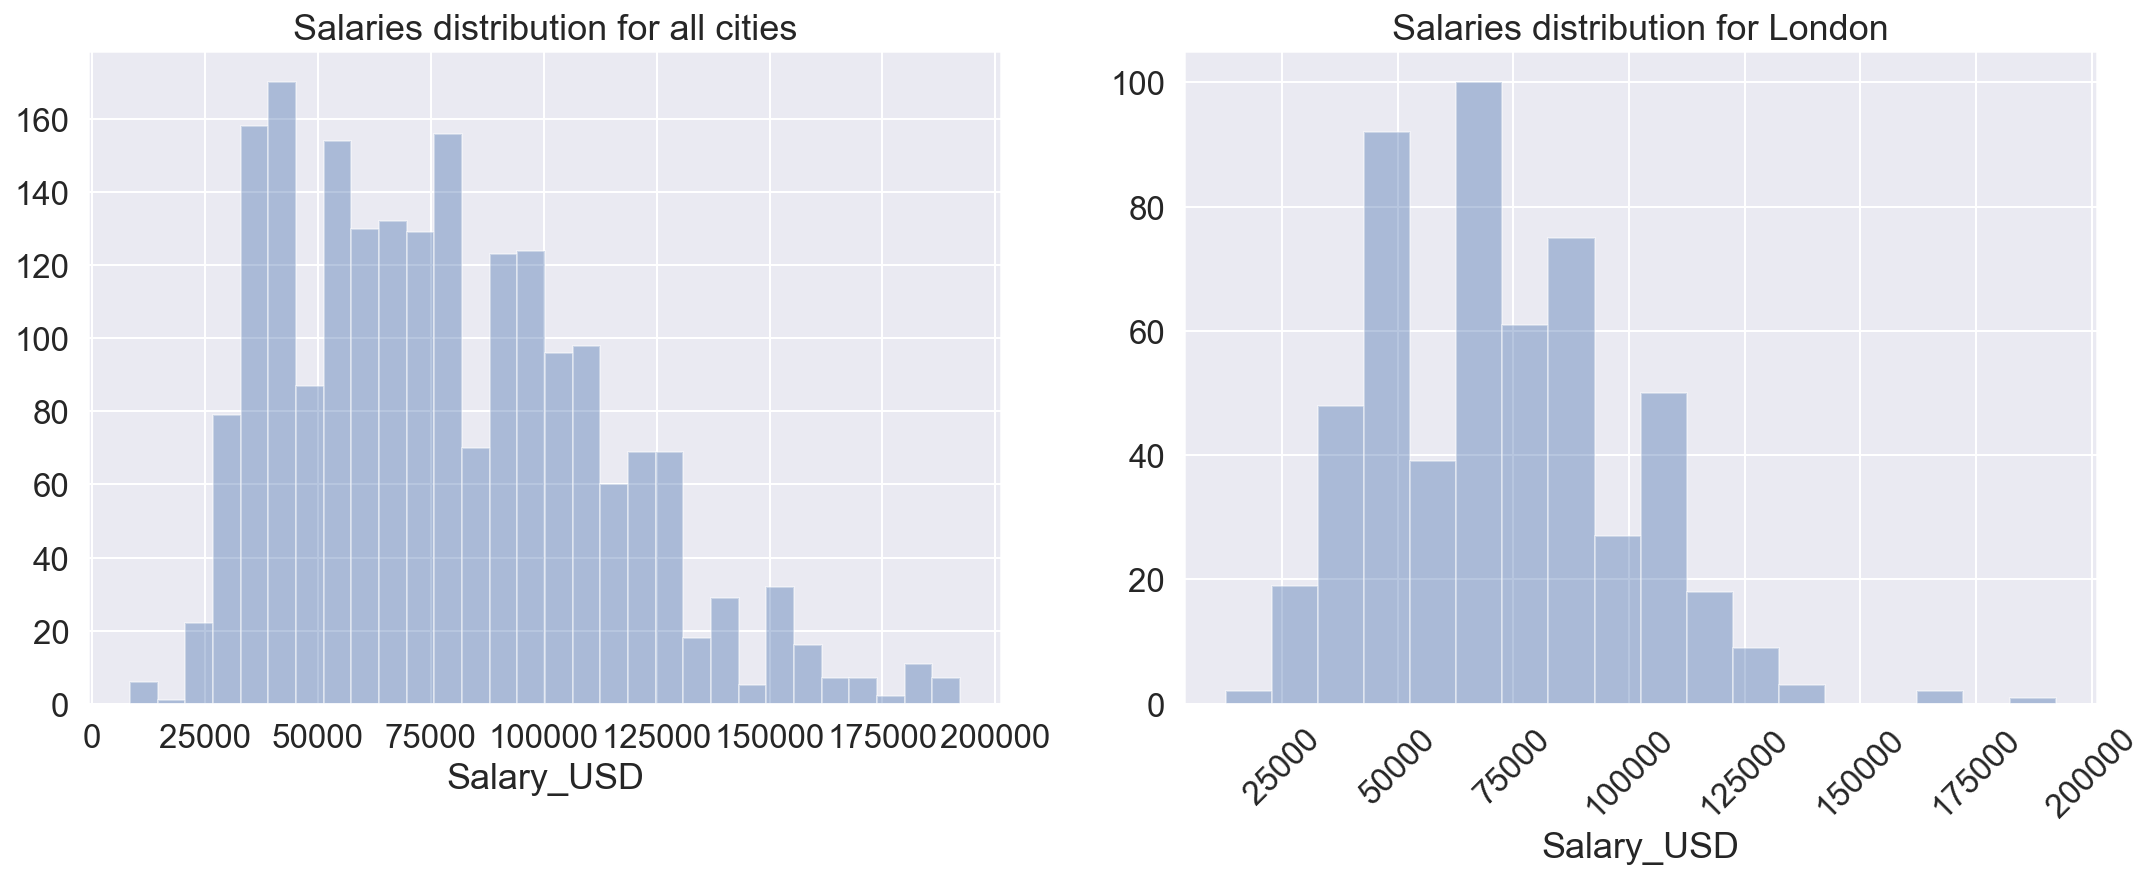

In [76]:
fig, ax = plt.subplots(ncols=2, figsize=(18, 6))
ax[0].set(title='Salaries distribution for all cities')
ax[0] = sns.distplot(job_df.Salary_USD, ax=ax[0],bins=30,kde=False)

ax[1].set(title='Salaries distribution for London')
plt.xticks(rotation=45) 
ax[1] = sns.distplot(job_df[job_df.City_clean=='London']['Salary_USD'], ax=ax[1],bins=18,kde=False)

plt.show()

In [77]:
from sklearn.metrics import confusion_matrix, classification_report

In [78]:
job_df.columns

Index(['Job', 'Location', 'City_clean', 'Salary_USD', 'Company', 'Link',
       'sal_bin', 'sal_thresh_70'],
      dtype='object')

In [79]:
y = job_df.pop('sal_bin')
X = job_df.copy()

In [80]:
#Dummify the location variable

X_dummy = pd.concat([X,pd.get_dummies(X[['City_clean']],drop_first=True,prefix='city')],axis=1)


In [81]:
X_dummy.head()

Job      Location City_clean  \
index                                                                        
0                 Senior Research Staff Assistant  New York, NY   New York   
1                      Associate Research Analyst  New York, NY   New York   
2      Sr Analyst, Data Management Quant Analysis  Syracuse, NY   New York   
3                 Postdoctoral Associate (R18-05)    Albany, NY   New York   
4                            Research Scientist I    Albany, NY   New York   

       Salary_USD                       Company  \
index                                             
0         45000.0           Columbia University   
1         40000.0              Harrington Starr   
2         45000.0                    BNY Mellon   
3         38000.0  Research Foundation for SUNY   
4         56326.0  Health Research Incorporated   

                                                    Link  sal_thresh_70  \
index                                                                     
0      https://www.indeed.com/rc/clk?jk=5def350ae6574...              0   
1      https://www.indeed.com/company/Harrington-Star...              0   
2      https://www.indeed.com/company/BNY-Mellon/jobs...              0   
3      https://www.indeed.com/rc/clk?jk=289e4a090399b...              0   
4      https://www.indeed.com/rc/clk?jk=f243890119947...              0   

       city_Austin  city_Bangor  city_Bath         ...          \
index                                              ...           
0                0            0          0         ...           
1                0            0          0         ...           
2                0            0          0         ...           
3                0            0          0         ...           
4                0            0          0         ...           

       city_Portsmouth  city_Raleigh  city_San Diego  city_San Francisco  \
index                                                                      
0                    0             0               0                   0   
1                    0             0               0                   0   
2                    0             0               0                   0   
3                    0             0               0                   0   
4                    0             0               0                   0   

       city_Seattle  city_Sheffield  city_Silicon Valley  city_St Albans  \
index                                                                      
0                 0               0                    0               0   
1                 0               0                    0               0   
2                 0               0                    0               0   
3                 0               0                    0               0   
4                 0               0                    0               0   

       city_St. Louis  city_Washington DC  
index                                      
0                   0                   0  
1                   0                   0  
2                   0                   0  
3                   0                   0  
4                   0                   0  

[5 rows x 52 columns]

In [82]:
#Train Test split

X_train,X_test,y_train,y_test = train_test_split(X_dummy,y,test_size=0.3, stratify=y,shuffle=True,random_state=30)


In [83]:
X_train_safe= X_train.copy()
X_train_dum = X_train.drop(columns= ['Job', 'Location', 'City_clean', 'Salary_USD',
                                     'Company', 'Link','sal_thresh_70'])
X_test_safe=X_test.copy()
X_test_dum = X_test.drop(columns= ['Job', 'Location', 'City_clean', 'Salary_USD', 'Company', 'Link','sal_thresh_70'])

In [84]:
#Standadize the dummy variables
X_train_std=pd.DataFrame(scaler.fit_transform(X_train_dum),columns=list(X_train_dum.columns))
X_test_std=pd.DataFrame(scaler.transform(X_test_dum),columns=list(X_train_dum.columns))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
X_train_std.head()

city_Austin  city_Bangor  city_Bath  city_Birmingham  city_Boston  \
0    -0.069746     -0.06455  -0.058905        -0.102383    -0.218692   
1    -0.069746     -0.06455  -0.058905        -0.102383    -0.218692   
2    -0.069746     -0.06455  -0.058905        -0.102383    -0.218692   
3    -0.069746     -0.06455  -0.058905        -0.102383    -0.218692   
4    -0.069746     -0.06455  -0.058905        -0.102383    -0.218692   

   city_Bradford  city_Brighton and Hove  city_Bristol  city_Cambridge  \
0      -0.087553               -0.118428     -0.079139       -0.195057   
1      -0.087553               -0.118428     -0.079139       -0.195057   
2      -0.087553               -0.118428     -0.079139       -0.195057   
3      -0.087553               -0.118428     -0.079139       -0.195057   
4      -0.087553               -0.118428     -0.079139       -0.195057   

   city_Canterbury         ...          city_Portsmouth  city_Raleigh  \
0        -0.058905         ...                -0.074587     -0.105777   
1        -0.058905         ...                -0.074587     -0.105777   
2        -0.058905         ...                -0.074587      9.453835   
3        -0.058905         ...                -0.074587     -0.105777   
4        -0.058905         ...                -0.074587     -0.105777   

   city_San Diego  city_San Francisco  city_Seattle  city_Sheffield  \
0       -0.129914           -0.215197     -0.155175        -0.06455   
1       -0.129914           -0.215197     -0.155175        -0.06455   
2       -0.129914           -0.215197     -0.155175        -0.06455   
3       -0.129914           -0.215197     -0.155175        -0.06455   
4       -0.129914           -0.215197     -0.155175        -0.06455   

   city_Silicon Valley  city_St Albans  city_St. Louis  city_Washington DC  
0            -0.222142       -0.058905       -0.135314           -0.242002  
1            -0.222142       -0.058905       -0.135314           -0.242002  
2            -0.222142       -0.058905       -0.135314           -0.242002  
3            -0.222142       -0.058905       -0.135314           -0.242002  
4            -0.222142       -0.058905       -0.135314           -0.242002  

[5 rows x 45 columns]

In [86]:
X_test_std.head()

city_Austin  city_Bangor  city_Bath  city_Birmingham  city_Boston  \
0    -0.069746     -0.06455  -0.058905        -0.102383    -0.218692   
1    -0.069746     -0.06455  -0.058905        -0.102383    -0.218692   
2    -0.069746     -0.06455  -0.058905        -0.102383    -0.218692   
3    -0.069746     -0.06455  -0.058905        -0.102383     4.572646   
4    -0.069746     -0.06455  -0.058905        -0.102383    -0.218692   

   city_Bradford  city_Brighton and Hove  city_Bristol  city_Cambridge  \
0      -0.087553               -0.118428     -0.079139       -0.195057   
1      -0.087553               -0.118428     -0.079139       -0.195057   
2      -0.087553               -0.118428     -0.079139       -0.195057   
3      -0.087553               -0.118428     -0.079139       -0.195057   
4      -0.087553               -0.118428     -0.079139       -0.195057   

   city_Canterbury         ...          city_Portsmouth  city_Raleigh  \
0        -0.058905         ...                -0.074587     -0.105777   
1        -0.058905         ...                -0.074587     -0.105777   
2        -0.058905         ...                -0.074587     -0.105777   
3        -0.058905         ...                -0.074587     -0.105777   
4        -0.058905         ...                -0.074587     -0.105777   

   city_San Diego  city_San Francisco  city_Seattle  city_Sheffield  \
0       -0.129914           -0.215197     -0.155175        -0.06455   
1       -0.129914           -0.215197     -0.155175        -0.06455   
2       -0.129914           -0.215197     -0.155175        -0.06455   
3       -0.129914           -0.215197     -0.155175        -0.06455   
4       -0.129914           -0.215197     -0.155175        -0.06455   

   city_Silicon Valley  city_St Albans  city_St. Louis  city_Washington DC  
0            -0.222142       -0.058905       -0.135314           -0.242002  
1            -0.222142       -0.058905       -0.135314           -0.242002  
2            -0.222142       -0.058905       -0.135314           -0.242002  
3            -0.222142       -0.058905       -0.135314           -0.242002  
4            -0.222142       -0.058905       -0.135314           -0.242002  

[5 rows x 45 columns]

#### SKLEARN model

In [87]:
def fitter(model, X_train, y_train, X_test, y_test):
    score = cross_val_score(lrmodel,X_train,y_train,cv=5)
    model.fit(X_train, y_train)
    print('Cross Validated traing scores:',score)
    print('Mean Cross Validated traing scores:',np.mean(score))
    print()
    print('Model Training score: \t',model.score(X_train, y_train))
    print('Model test score: \t',model.score(X_test, y_test))
    print('=============================================\n CONFUSION MATRIX')
    print(pd.DataFrame(confusion_matrix(y_test, model.predict(X_test))))
    print('=============================================')
    print(classification_report(y_test, model.predict(X_test)))
    return model

In [88]:
lrmodel = LogisticRegression(solver='lbfgs')
lrmodel = fitter(lrmodel, X_train_std, y_train, X_test_std, y_test)

Cross Validated traing scores: [0.72068966 0.6862069  0.67820069 0.69896194 0.70833333]
Mean Cross Validated traing scores: 0.6984785029630514

Model Training score: 	 0.7116182572614108
Model test score: 	 0.6811594202898551
 CONFUSION MATRIX
     0    1
0  222   89
1  109  201
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       311
           1       0.69      0.65      0.67       310

   micro avg       0.68      0.68      0.68       621
   macro avg       0.68      0.68      0.68       621
weighted avg       0.68      0.68      0.68       621



In [89]:
#Get a list of all the coeficients/intercept (actual and absolute)

intercept=pd.DataFrame()
intercept['Coefs']=lrmodel.intercept_.T


lrcoefs = pd.DataFrame(lrmodel.coef_,columns=X_test_dum.columns,index=['Coefs']).T

lrcoefs= lrcoefs.append(intercept)
lrcoefs.rename_axis({0:'intercept'},inplace=True)

lrcoefs['coef_abs']=abs(lrcoefs['Coefs'])
lrcoefs.sort_values(by='coef_abs',ascending=False,inplace=True)


In [90]:
lrcoefs.rename(columns={'Coefs':'SKLearn_Coefs'},inplace=True)

In [91]:
from sklearn.metrics import roc_curve, auc

In [92]:
def ROC_plotter(X,model,y_test):

    Y_pp = pd.DataFrame(model.predict_proba(X), columns=['low','high'])
    fpr, tpr, threshold = roc_curve(y_test, Y_pp.high)
    roc_auc = auc(fpr, tpr)


    plt.figure(figsize=[8,8])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

In [93]:
def pr_plotter(X,y,model):
    fig, ax = plt.subplots(figsize=(10,8))
    skplt.metrics.plot_precision_recall(y,model.predict_proba(X), 
                           plot_micro=True, 
                           title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
    ax.legend(loc=[1.1,0])
    plt.show()

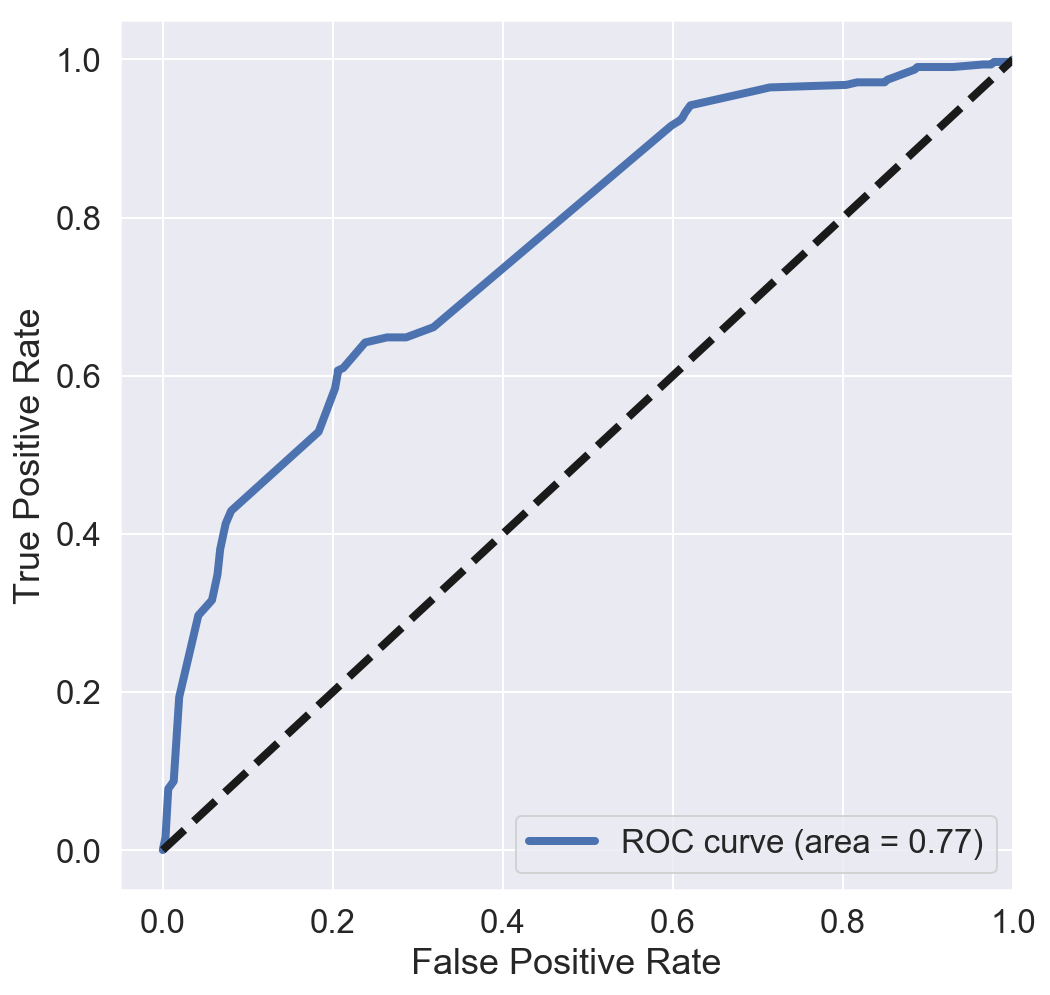

In [94]:
ROC_plotter(X_test_std,lrmodel,y_test)

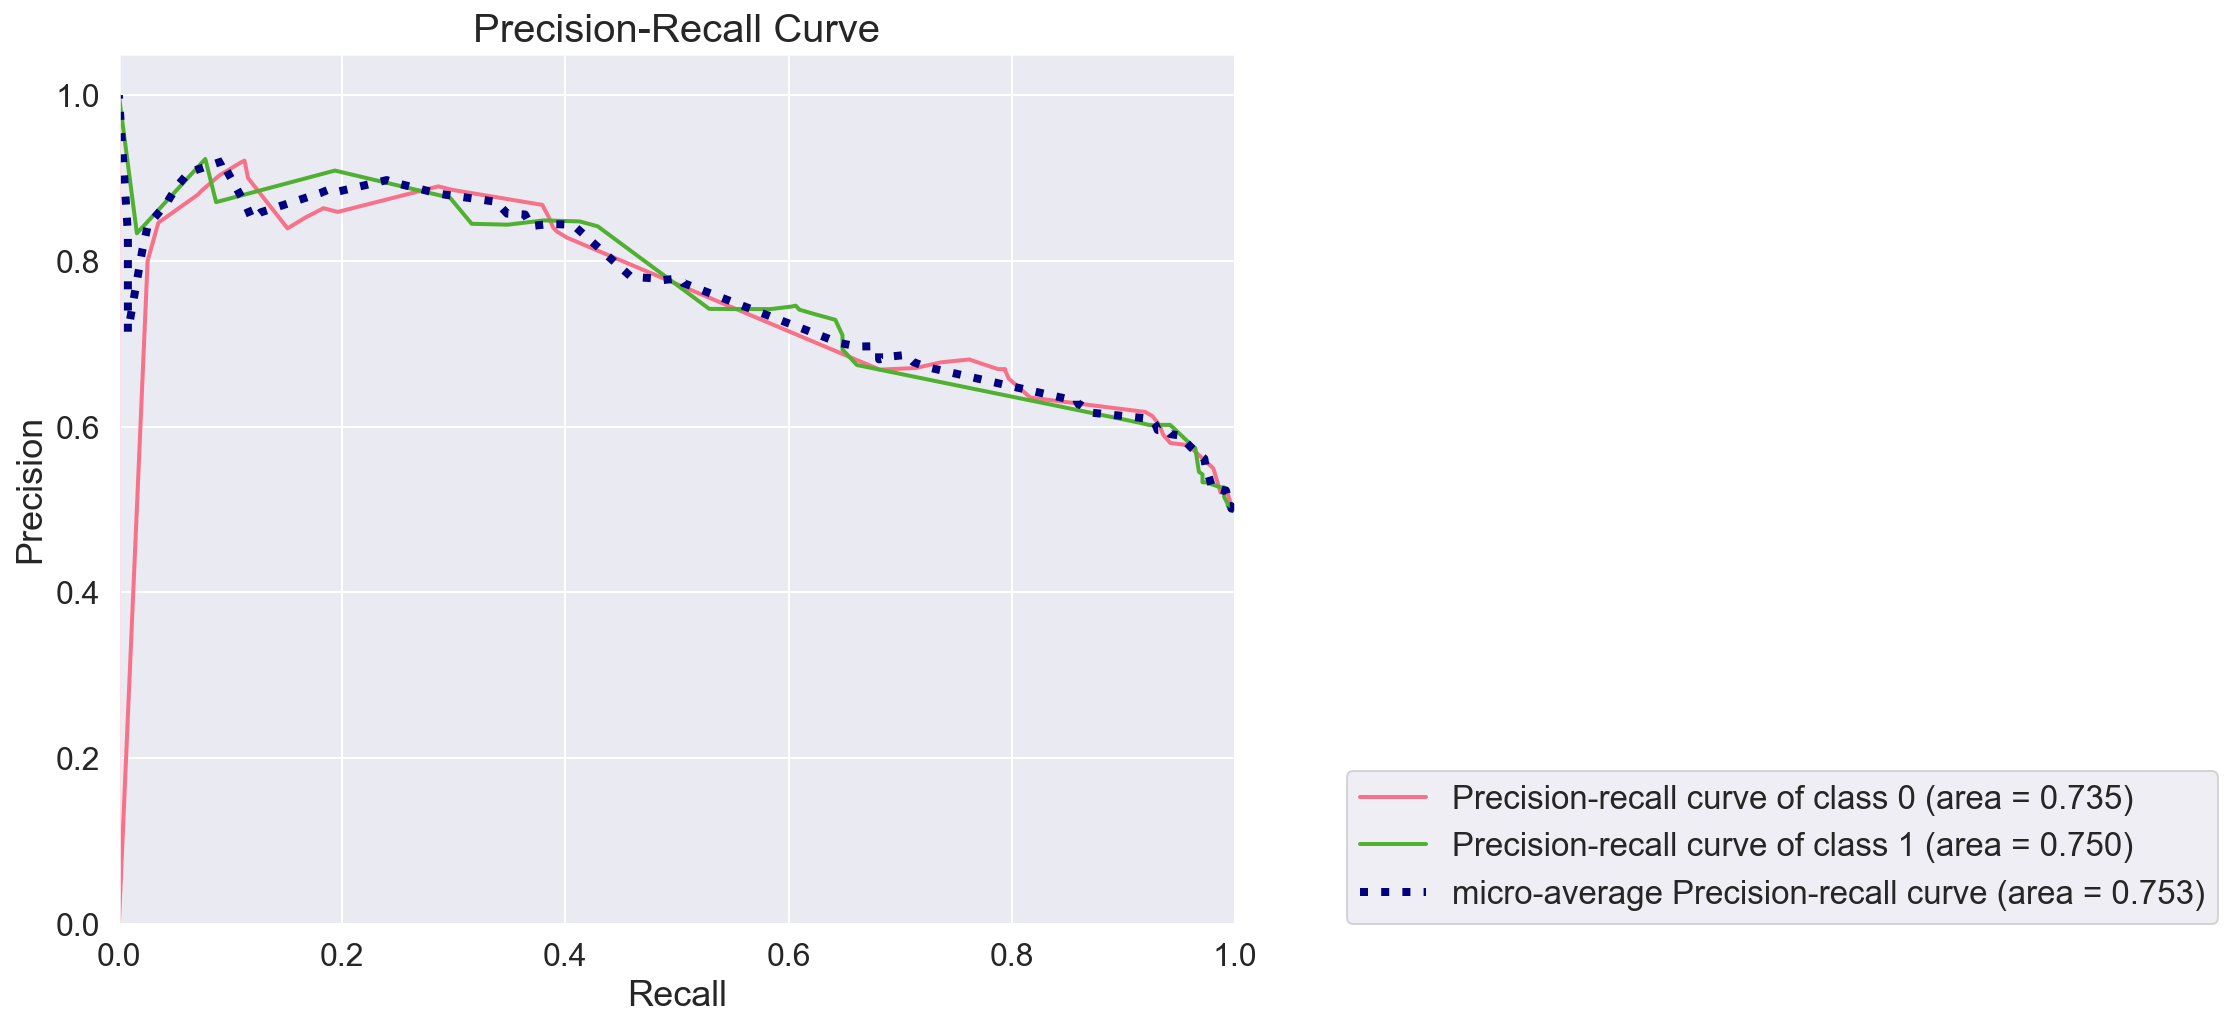

In [95]:
pr_plotter(X_test_std,y_test,lrmodel)

### STATSMODELs model

In [96]:
import statsmodels.formula.api as sm

In [97]:
y_i=np.array(y_train)

In [98]:
X_i = X_train_std.copy()
X_i['intercept'] = 1
X_i_test=X_test_std.copy()
X_i_test['intercept'] = 1
lr_stats_model = sm.Logit(y_i,X_i).fit(method='lbfgs')

lr_stats_model.summary2()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: Logit
=======================================================================
Model:                Logit              Pseudo R-squared:   0.231     
Dependent Variable:   y                  AIC:                1632.5782 
Date:                 2018-11-26 22:13   BIC:                1875.2998 
No. Observations:     1446               Log-Likelihood:     -770.29   
Df Model:             45                 LL-Null:            -1002.3   
Df Residuals:         1400               LLR p-value:        5.8408e-71
Converged:            1.0000             Scale:              1.0000    
No. Iterations:       18.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
-----------------------------------------------------------------------
city_Austin             0.9014  23.2712  0.0387 0.9691 -44.7094 46.5121
city_Bangor            -0.1414   0.0790 -1.7887 0.0737  -0.2962  0.0135
city_Bath              -0.0108   0.0628 -0.1721 0.8634  -0.1339  0.1123
city_Birmingham        -0.2494   0.0955 -2.6117 0.0090  -0.4365 -0.0622
city_Boston            -0.0198   0.1279 -0.1548 0.8770  -0.2705  0.2309
city_Bradford          -1.0995  10.9148 -0.1007 0.9198 -22.4920 20.2931
city_Brighton and Hove -0.0688   0.0835 -0.8244 0.4097  -0.2325  0.0948
city_Bristol           -0.2099   0.0942 -2.2270 0.0259  -0.3946 -0.0252
city_Cambridge         -0.4090   0.1254 -3.2623 0.0011  -0.6547 -0.1633
city_Canterbury        -0.7427  10.9309 -0.0679 0.9458 -22.1669 20.6815
city_Cardiff           -0.7427  10.9309 -0.0679 0.9458 -22.1669 20.6815
city_Chester           -1.0486  10.9175 -0.0961 0.9235 -22.4465 20.3492
city_Chicago            0.0695   0.0840  0.8276 0.4079  -0.0951  0.2341
city_Chichester        -0.0379   0.0636 -0.5961 0.5511  -0.1625  0.0867
city_Dallas             0.1006   0.0894  1.1247 0.2607  -0.0747  0.2759
city_Denver            -0.0454   0.0837 -0.5427 0.5873  -0.2094  0.1186
city_Derby             -1.0995  10.9148 -0.1007 0.9198 -22.4920 20.2931
city_Durham            -0.9952  10.9202 -0.0911 0.9274 -22.3983 20.4080
city_Edinburgh         -0.1653   0.0844 -1.9588 0.0501  -0.3307  0.0001
city_Exeter            -0.1414   0.0790 -1.7887 0.0737  -0.2962  0.0135
city_Glasgow           -1.0486  10.9175 -0.0961 0.9235 -22.4465 20.3492
city_Gloucester        -1.2391  10.9066 -0.1136 0.9095 -22.6157 20.1375
city_Houston           -0.0454   0.0897 -0.5062 0.6127  -0.2212  0.1304
city_Lancaster         -0.5757  10.9363 -0.0526 0.9580 -22.0104 20.8590
city_London            -0.3666   0.2497 -1.4679 0.1421  -0.8561  0.1229
city_Los Angeles        0.0602   0.0989  0.6081 0.5431  -0.1337  0.2541
city_Manchester        -0.3839   0.1153 -3.3303 0.0009  -0.6098 -0.1579
city_Miami             -0.1000   0.0753 -1.3281 0.1841  -0.2476  0.0476
city_New York          -0.0242   0.1787 -0.1353 0.8923  -0.3744  0.3260
city_Norwich           -0.2513   0.1032 -2.4345 0.0149  -0.4536 -0.0490
city_Oxford            -0.4851   0.1404 -3.4559 0.0005  -0.7602 -0.2100
city_Philadelphia       0.0655   0.1030  0.6355 0.5251  -0.1365  0.2674
city_Phoenix           -0.2166   0.0897 -2.4155 0.0157  -0.3923 -0.0408
city_Pittsburgh        -0.1532   0.0789 -1.9421 0.0521  -0.3077  0.0014
city_Portland          -0.0584   0.0628 -0.9299 0.3524  -0.1815  0.0647
city_Portsmouth        -0.1252   0.0734 -1.7072 0.0878  -0.2690  0.0185
city_Raleigh           -0.0354   0.0786 -0.4498 0.6528  -0.1895  0.1188
city_San Diego          0.0952   0.0959  0.9927 0.3208  -0.0928  0.2833
city_San Francisco      0.2510   0.1365  1.8389 0.0659  -0.0165  0.5186
city_Seattle            0.0433   0.1020  0.4249 0.6709  -0.1565  0.2432
city_Sheffield         -0.1414   0.0790 -1.7887 0.0737  -0.2962  0.0135
city_Silicon Valley     0.6153   0.1924  3.1976 0.0014   0.2381  0.9924
city_St Albans      

In [99]:
y_hat_stmod=[1 if i >=0.5 else 0 for i in lr_stats_model.predict(X_i_test)]

In [100]:
print(pd.DataFrame(confusion_matrix(y_test,y_hat_stmod)))
print('=========================================')
print(classification_report(y_test,y_hat_stmod))

     0    1
0  222   89
1  109  201
              precision    recall  f1-score   support

           0       0.67      0.71      0.69       311
           1       0.69      0.65      0.67       310

   micro avg       0.68      0.68      0.68       621
   macro avg       0.68      0.68      0.68       621
weighted avg       0.68      0.68      0.68       621



In [101]:
# Do the models predict the same result?
print('There are ',abs((lrmodel.predict(X_test_std)-(y_hat_stmod)).sum()),
      'predictions that are predicted differently between the models ('
      ,round(abs((lrmodel.predict(X_test_std)-(y_hat_stmod)).sum()/len(y_test)*100),1),'% of total predictions)')


There are  0 predictions that are predicted differently between the models ( 0.0 % of total predictions)


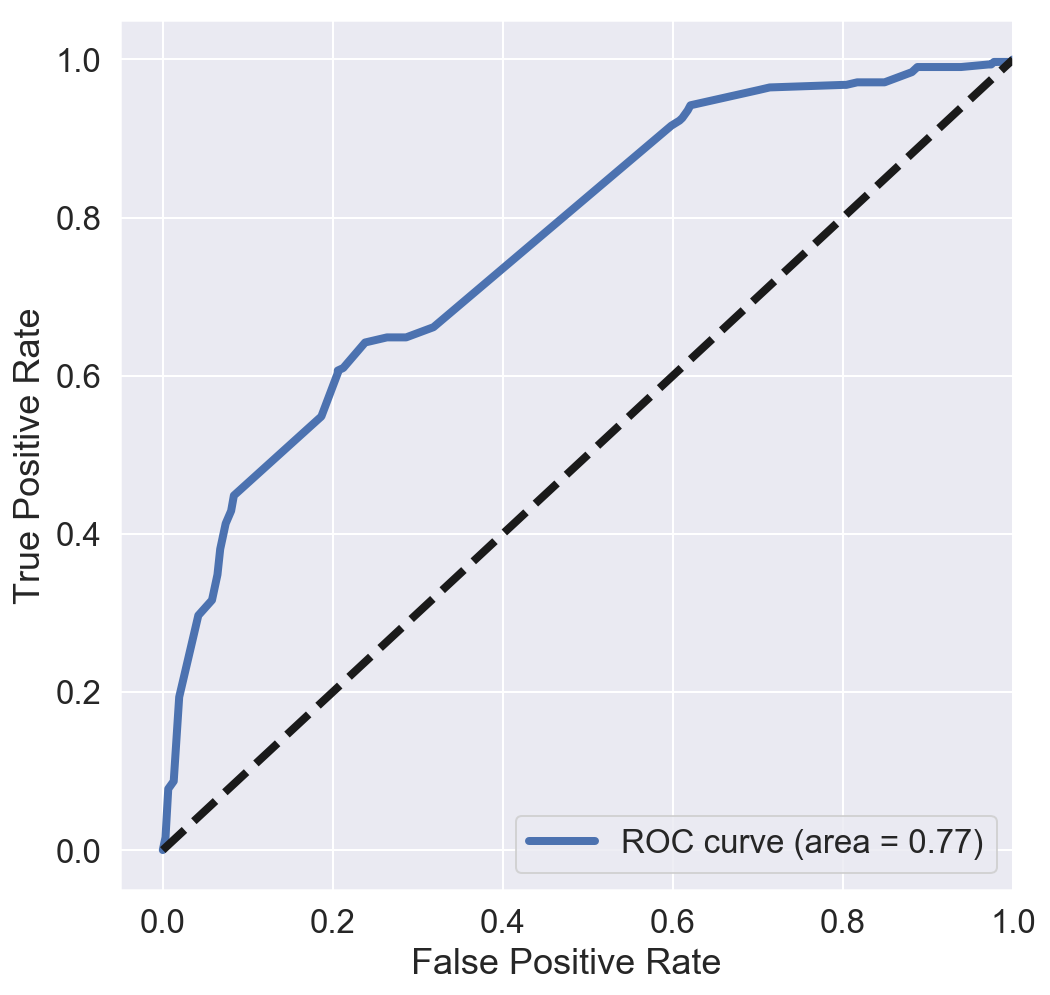

In [102]:
Y_pp = pd.DataFrame(lr_stats_model.predict(X_i_test), columns=['low'])
fpr, tpr, threshold = roc_curve(y_test, Y_pp.low)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=[8,8])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [103]:
stats_coef = pd.DataFrame(lr_stats_model.params,columns=['Stats_model_coef'])

In [104]:
coefs_comb = pd.concat([lrcoefs,stats_coef],join='outer',axis=1).sort_values(by='coef_abs',ascending=False)

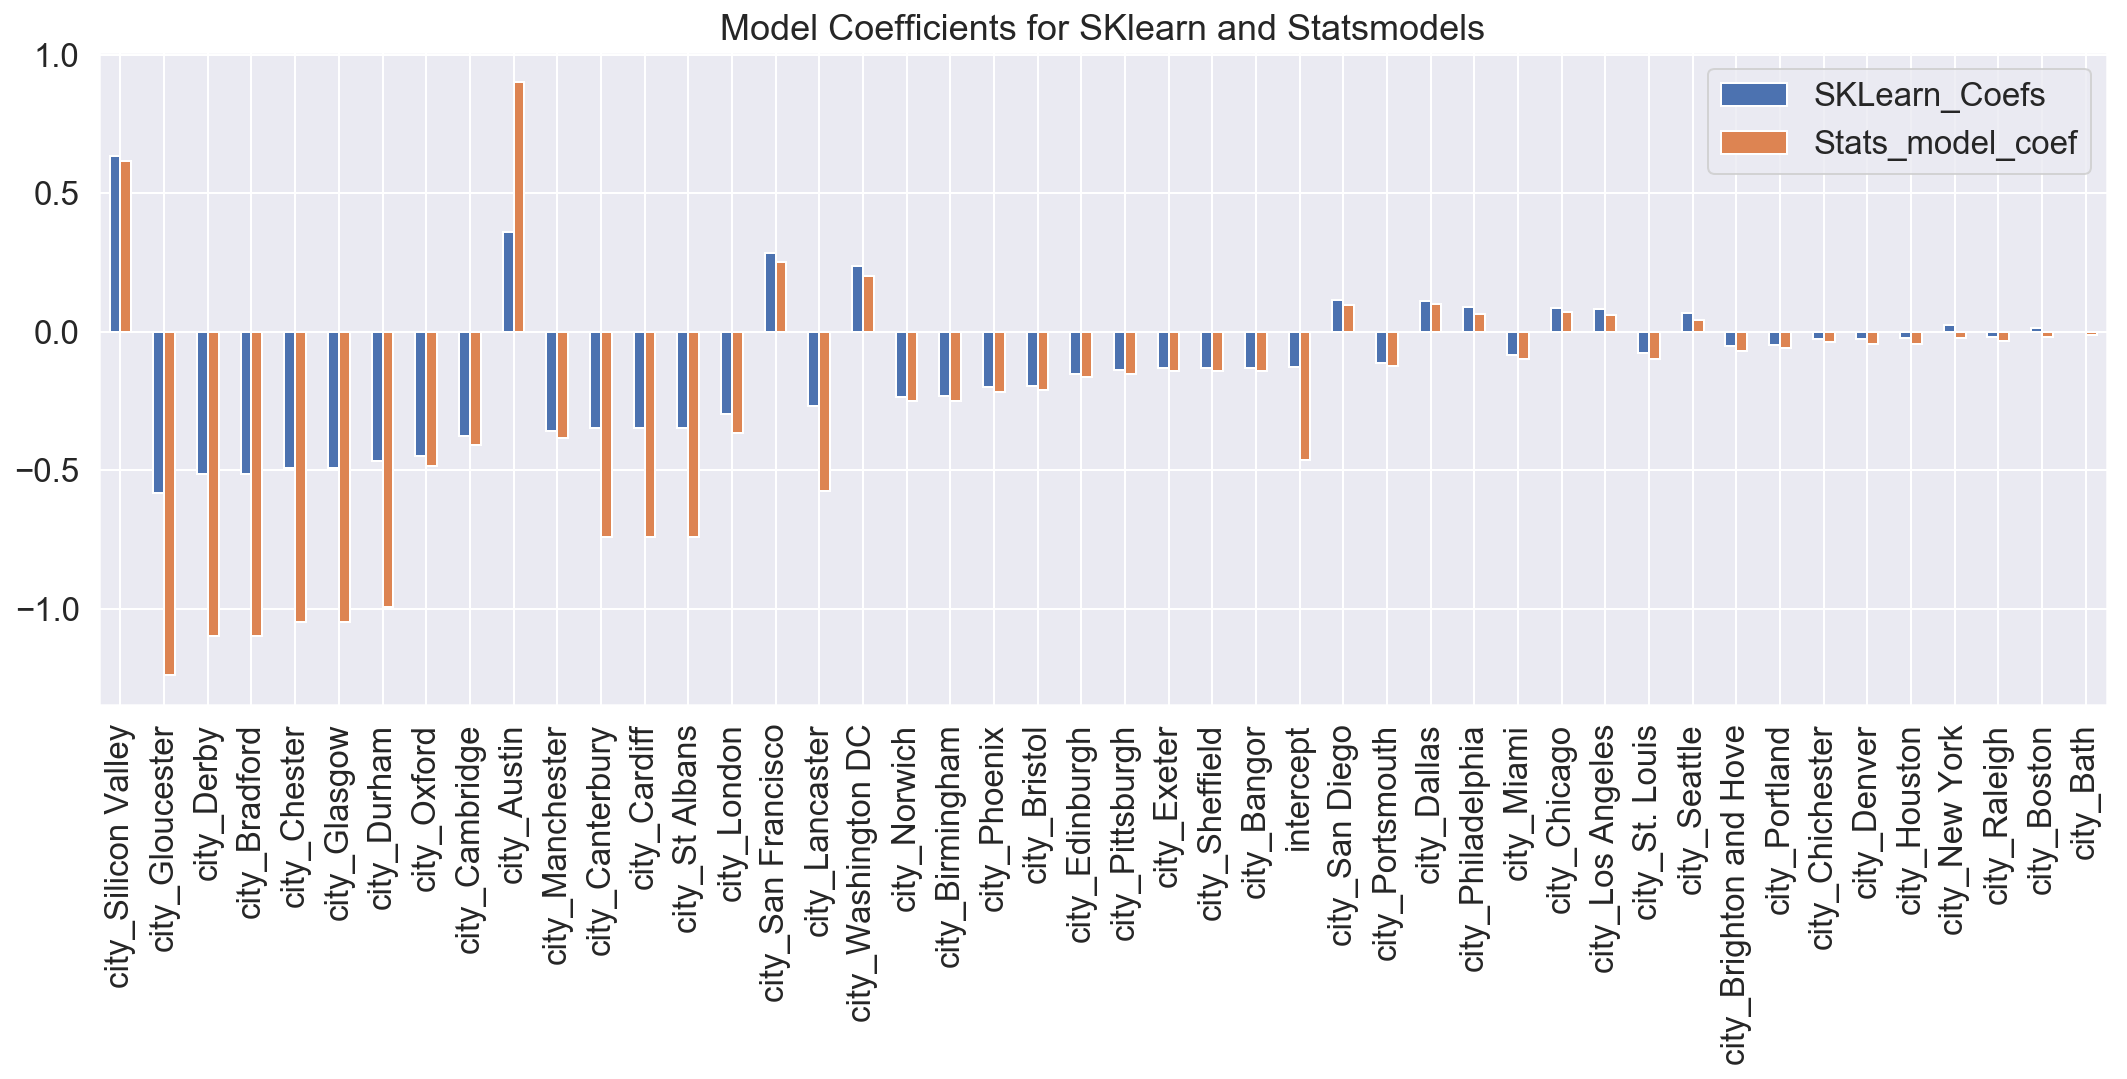

In [105]:
#Plot the coeficients of each model against each other.
fig,ax = plt.subplots(figsize=(18, 6))

ax = coefs_comb[['SKLearn_Coefs','Stats_model_coef']].plot(kind='bar',ax=ax,title ='Model Coefficients for SKlearn and Statsmodels');



#### SKLearn vs Stats.Models
sklearn and Stat_models both predict the same sign of the coefficents, however the scale of the coefficints is different. I believe that this is due to the regularization automatically applied in the sklearn LogisticRegression module. Stats_models does not include this by default.

#### Location Coefficient explanation

The location coefficients predict the probability that a jobs salary is higher or lower than the median. These are binary variables, with only one location present at a time, therefore if the coefficient is positive then the salary will be returned as high. if the coeficient is negative then the salary will be returned as low. the coefiecints appear to be strongly correlated to the average salary in each city. 

In [106]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV


In [107]:
gs_params = {'C':np.logspace(-3,3,15)}
model=LogisticRegression(penalty='l2',solver='lbfgs')

gs=GridSearchCV(model,gs_params,cv=5,n_jobs=-1)
lr_mod=fitter(gs, X_train_dum, y_train, X_test_dum, y_test)

Cross Validated traing scores: [0.70344828 0.68275862 0.67474048 0.70588235 0.70486111]
Mean Cross Validated traing scores: 0.6943381690066155

Model Training score: 	 0.7116182572614108
Model test score: 	 0.6924315619967794
 CONFUSION MATRIX
     0    1
0  229   82
1  109  201
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       311
           1       0.71      0.65      0.68       310

   micro avg       0.69      0.69      0.69       621
   macro avg       0.69      0.69      0.69       621
weighted avg       0.69      0.69      0.69       621



/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [108]:
#The Logistic regression CV is worse than straight logistic regression.

In [109]:
lr_mod.best_params_

{'C': 138.9495494373136}

   ## Additional classifier - Random Forest

In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [111]:
gs_params = {'max_depth' : [None,3,4,5,6,7,8,9,10],
            'min_samples_split':[2,3,5,7,10],
            'max_features':np.linspace(0.1,1.0,10)}

                            
model=RandomForestClassifier(n_estimators=100,n_jobs=-1,random_state=10)

gs=GridSearchCV(model,gs_params,cv=5,n_jobs=-1,verbose=1)
forest=fitter(gs, X_train_std, y_train, X_test_std, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:  3.8min finished


Cross Validated traing scores: [0.72068966 0.6862069  0.67820069 0.69896194 0.70833333]
Mean Cross Validated traing scores: 0.6984785029630514

Model Training score: 	 0.7116182572614108
Model test score: 	 0.6908212560386473
 CONFUSION MATRIX
     0    1
0  230   81
1  111  199
              precision    recall  f1-score   support

           0       0.67      0.74      0.71       311
           1       0.71      0.64      0.67       310

   micro avg       0.69      0.69      0.69       621
   macro avg       0.69      0.69      0.69       621
weighted avg       0.69      0.69      0.69       621



In [112]:
forest_best= forest.best_estimator_

In [113]:
forest_best.fit(X_train_std,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=0.1, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=10, verbose=0, warm_start=False)

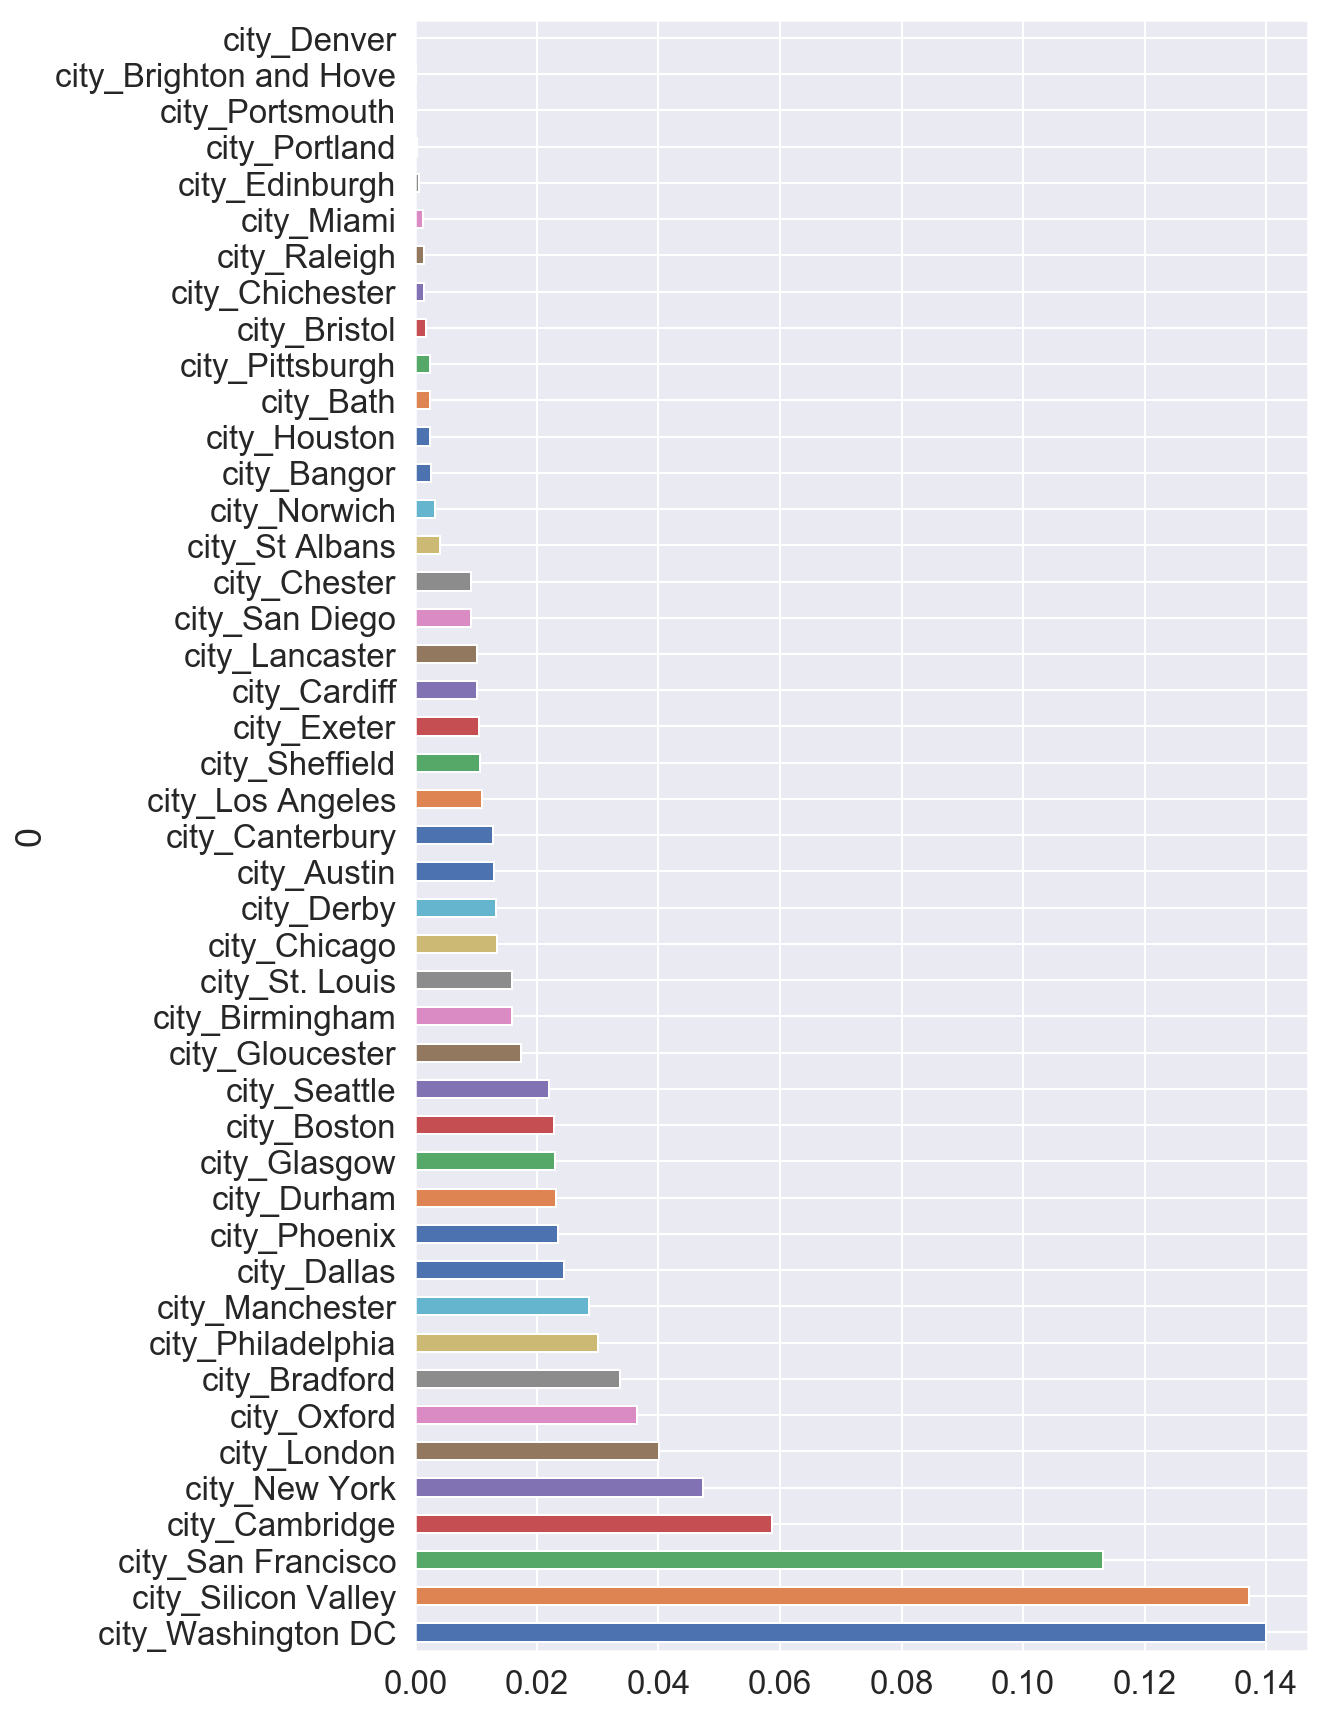

In [114]:
pd.DataFrame(list(zip(X_train_dum.columns,forest_best[1].feature_importances_))).sort_values(by=1,ascending=False).plot(kind='barh',
    x=0,y=1,figsize=(8,15),legend = False)
plt.show()

### Desision Tree Importances

The desision tree importance values show how important the coefficint is to making the overall desision for each variable. Values that have 0 importance were not used in the calculation of the random forest, while high importance indicates that more information gain was made each time that feature is used in a desision.

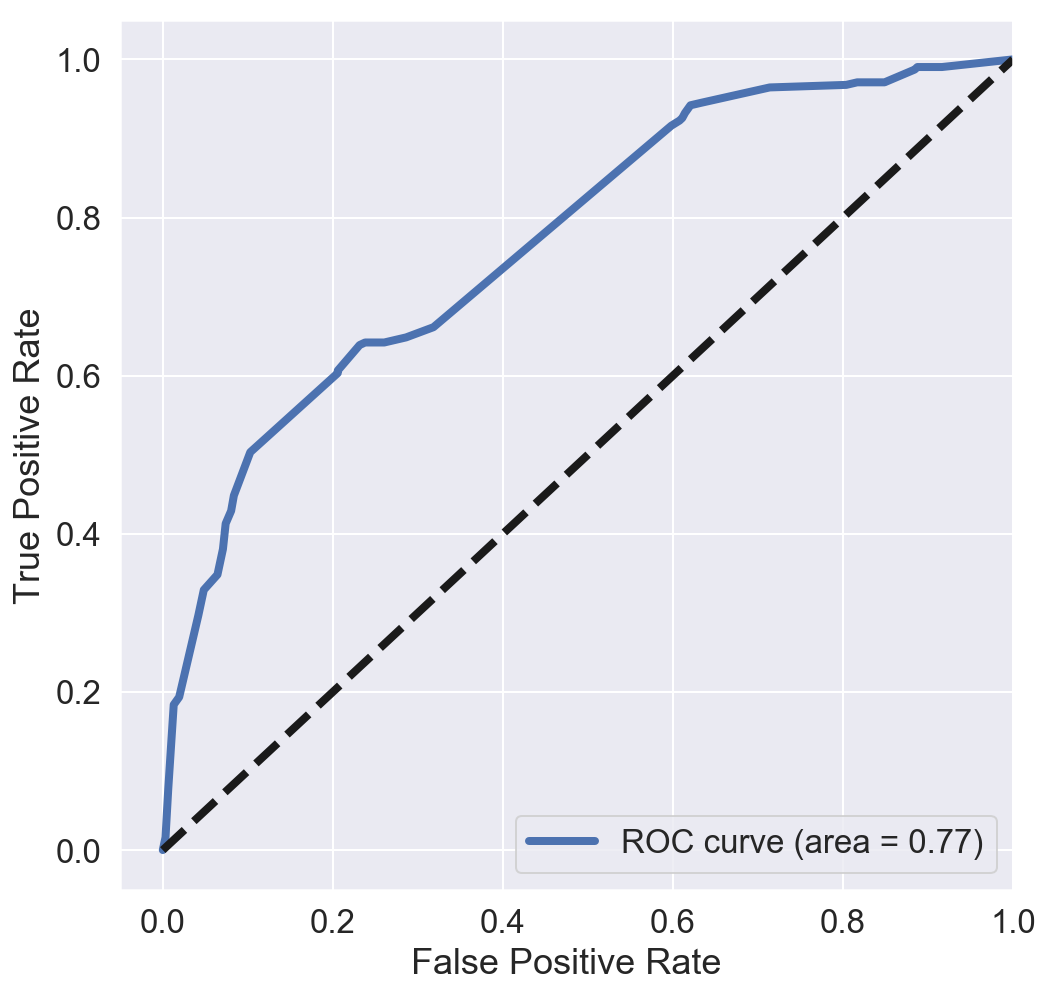

In [115]:
ROC_plotter(X_test_std,forest_best,y_test)

## Extract key words


In [116]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import numpy as np

In [117]:
cvec = CountVectorizer(stop_words='english',max_features=50,binary=True,ngram_range=(1,3))
cvec.fit(X_train.Job)
document_matrix_train = cvec.transform(X_train.Job)
document_matrix_test = cvec.transform(X_test.Job)
df_train = pd.DataFrame(document_matrix_train.toarray(),columns=cvec.get_feature_names())
df_test = pd.DataFrame(document_matrix_test.toarray(),columns=cvec.get_feature_names())
df_train.transpose().sort_values(0, ascending=False).transpose().head()

analytics  data  data scientist  scientist  ai  senior  principal  product  \
0          1     1               1          1   0       0          0        0   
1          0     0               0          0   0       0          0        0   
2          0     0               0          0   0       0          0        0   
3          0     0               0          0   0       0          0        0   
4          0     0               0          0   0       0          0        0   

   python  quantitative      ...       engineer  fellow  java  lead  \
0       0             0      ...              0       0     0     0   
1       0             0      ...              0       0     0     0   
2       0             0      ...              0       0     0     0   
3       0             0      ...              1       0     0     0   
4       0             0      ...              1       0     0     0   

   lead data  lead data scientist  learning  learning engineer  machine  \
0          0                    0         0                  0        0   
1          0                    0         0                  0        0   
2          0                    0         0                  0        0   
3          0                    0         1                  1        1   
4          0                    0         1                  1        1   

   statistician  
0             0  
1             0  
2             0  
3             0  
4             0  

[5 rows x 50 columns]

In [118]:
df_train.describe()

ai      analyst    analytics    assistant    associate  \
count  1446.000000  1446.000000  1446.000000  1446.000000  1446.000000   
mean      0.017289     0.094744     0.028354     0.013140     0.024896   
std       0.130391     0.292963     0.166040     0.113912     0.155863   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               big     big data       bureau         data  data analyst  \
count  1446.000000  1446.000000  1446.000000  1446.000000   1446.000000   
mean      0.014523     0.014523     0.015906     0.405947      0.019364   
std       0.119674     0.119674     0.125155     0.491244      0.137848   
min       0.000000     0.000000     0.000000     0.000000      0.000000   
25%       0.000000     0.000000     0.000000     0.000000      0.000000   
50%       0.000000     0.000000     0.000000     0.000000      0.000000   
75%       0.000000     0.000000     0.000000     1.000000      0.000000   
max       1.000000     1.000000     1.000000     1.000000      1.000000   

           ...       senior data scientist  senior software  \
count      ...                 1446.000000      1446.000000   
mean       ...                    0.031812         0.020747   
std        ...                    0.175560         0.142585   
min        ...                    0.000000         0.000000   
25%        ...                    0.000000         0.000000   
50%        ...                    0.000000         0.000000   
75%        ...                    0.000000         0.000000   
max        ...                    1.000000         1.000000   

       senior software engineer     software  software engineer   specialist  \
count               1446.000000  1446.000000        1446.000000  1446.000000   
mean                   0.015214     0.089212           0.062241     0.013140   
std                    0.122447     0.285148           0.241676     0.113912   
min                    0.000000     0.000000           0.000000     0.000000   
25%                    0.000000     0.000000           0.000000     0.000000   
50%                    0.000000     0.000000           0.000000     0.000000   
75%                    0.000000     0.000000           0.000000     0.000000   
max                    1.000000     1.000000           1.000000     1.000000   

                sr        staff  statistical  statistician  
count  1446.000000  1446.000000  1446.000000   1446.000000  
mean      0.030429     0.013140     0.013831      0.017289  
std       0.171823     0.113912     0.116831      0.130391  
min       0.000000     0.000000     0.000000      0.000000  
25%       0.000000     0.000000     0.000000      0.000000  
50%       0.000000     0.000000     0.000000      0.000000  
75%       0.000000     0.000000     0.000000      0.000000  
max       1.000000     1.000000     1.000000      1.000000  

[8 rows x 50 columns]

In [119]:
df_train.sum(axis=0).sort_values(ascending=False)

data                         587
scientist                    535
data scientist               376
engineer                     307
senior                       234
research                     149
learning                     147
machine                      141
analyst                      137
machine learning             137
software                     129
software engineer             90
developer                     83
manager                       69
senior data                   68
data engineer                 62
lead                          61
science                       61
data science                  53
learning engineer             48
machine learning engineer     48
python                        46
senior data scientist         46
sr                            44
analytics                     41
research analyst              36
associate                     36
product                       32
senior software               30
data analyst                  28
research s

Run the title count vectorized data frame only with logistic regression to see which words are important

Cross Validated traing scores: [0.65862069 0.63448276 0.71280277 0.68512111 0.64583333]
Mean Cross Validated traing scores: 0.6673721314083443

Model Training score: 	 0.6791147994467497
Model test score: 	 0.6940418679549114
 CONFUSION MATRIX
     0    1
0  215   96
1   94  216
              precision    recall  f1-score   support

           0       0.70      0.69      0.69       311
           1       0.69      0.70      0.69       310

   micro avg       0.69      0.69      0.69       621
   macro avg       0.69      0.69      0.69       621
weighted avg       0.69      0.69      0.69       621



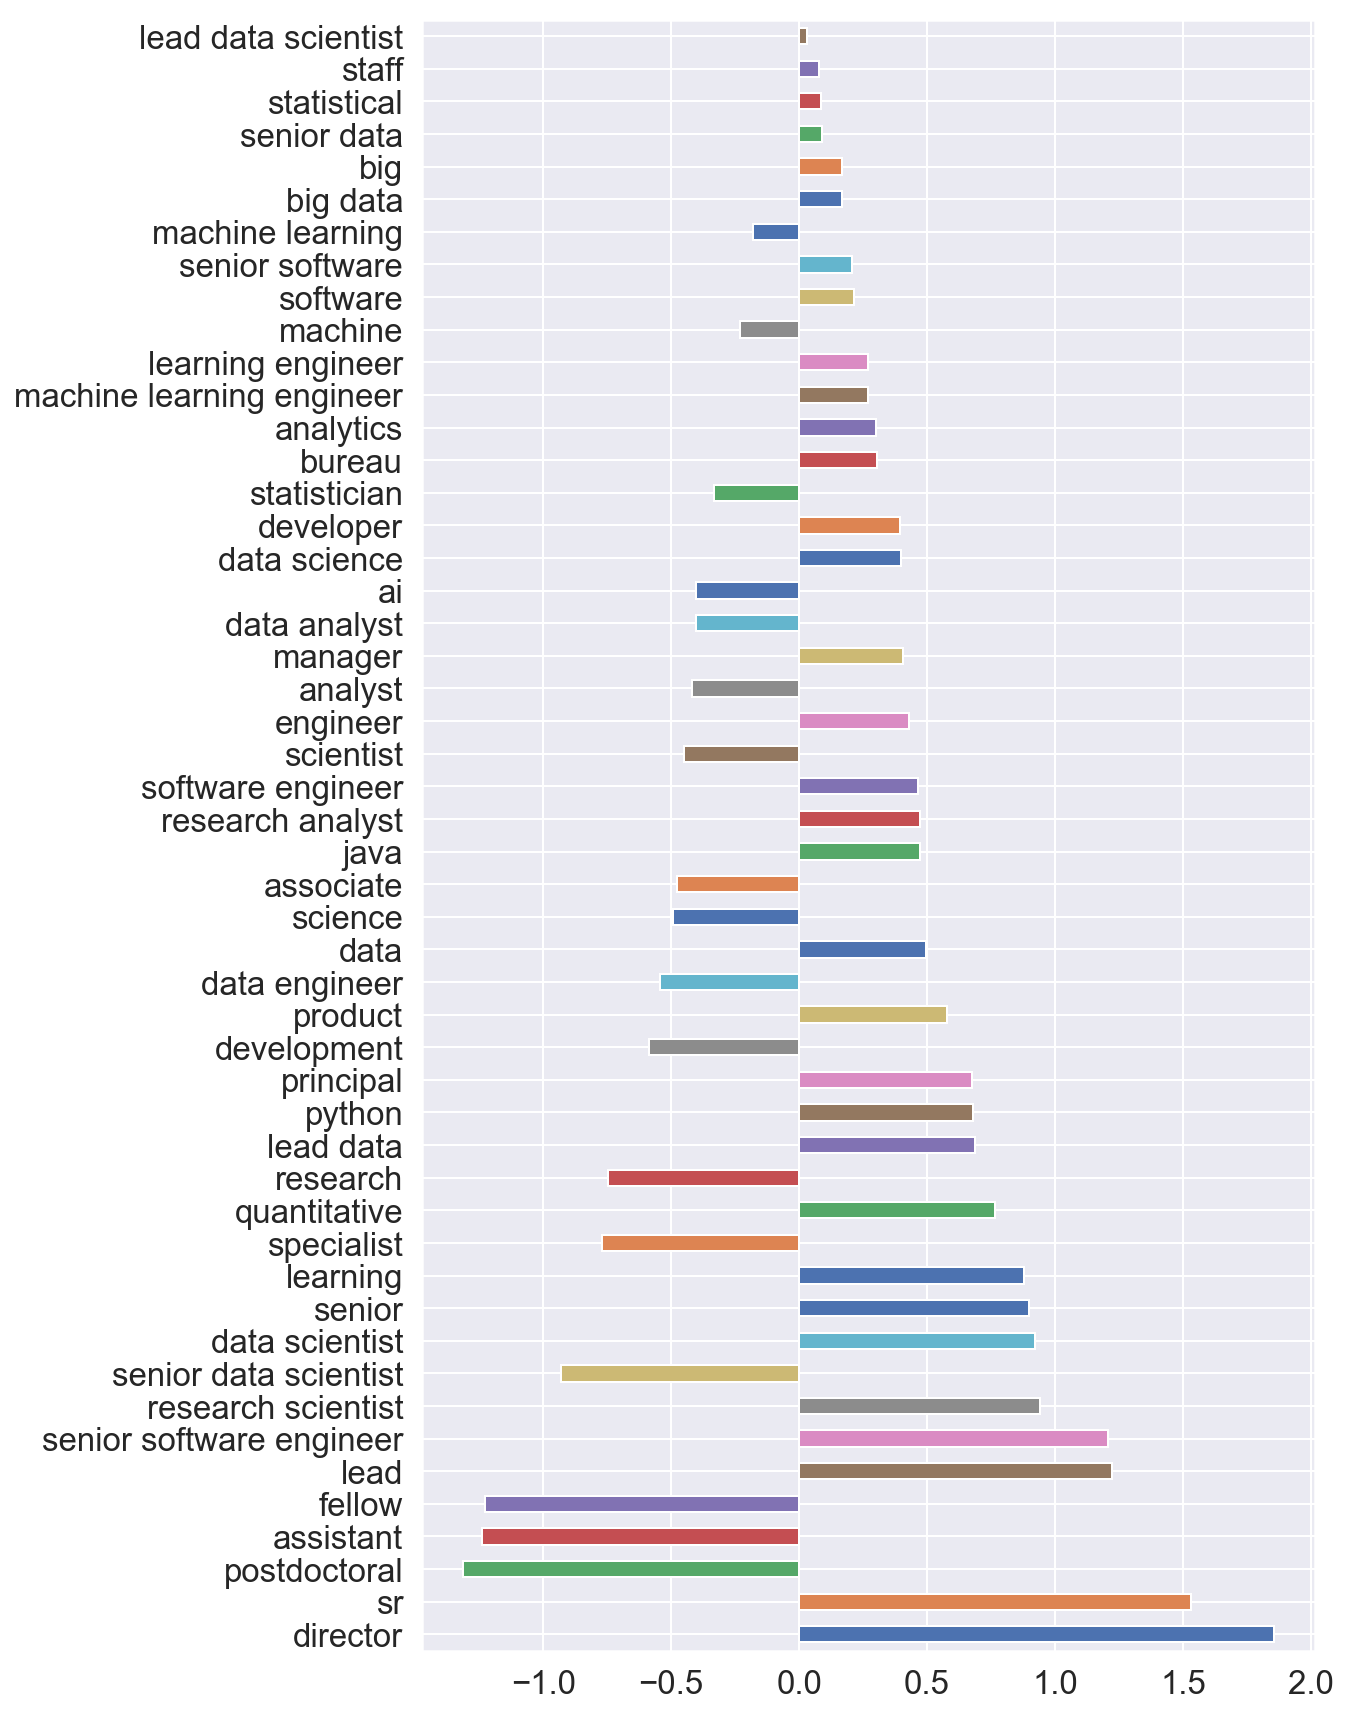

In [123]:
lrmodel_title=LogisticRegression()
fitter(lrmodel_title,df_train,y_train,df_test,y_test)
lrcoefs = pd.DataFrame(lrmodel_title.coef_,columns=df_train.columns,index=['Coefs']).T
lrcoefs['coef_abs']=abs(lrcoefs['Coefs'])
lrcoefs.sort_values(by='coef_abs',ascending=False,inplace=True)
lrcoefs.plot(y='Coefs',kind='barh',figsize=(8,15),legend=False);

### Coeficient explanation

the job job title word coeffiecients predict the probability of a job salary being high or low. Positive coefiencts increase the probability the salary will be high if the word/combination of words is found in the job title. Words whose coefficient is negitive increase the probability that the salary will be below the median. 'sr','lead and 'director' are the strongest predictors that a salary will be high, and words such as 'fellow', 'research', and 'specialist' when found in isolation strongly increase the probabiltity that the salary will be low. However some strings, such as 'research scientist' are strong high salary predictors when used in combination. coefficients that are close to zero are very weak predictors and could be removed for model refinement.

## Combine the job title and location data frames.

Use both job location and the job title words will be used in comination as predictors

In [124]:
X_train_full = pd.concat([X_train_std,df_train],axis=1)
X_test_full = pd.concat([X_test_std,df_test],axis=1)

Cross Validated traing scores: [0.77931034 0.73103448 0.74740484 0.78892734 0.75347222]
Mean Cross Validated traing scores: 0.7600298459478451

Model Training score: 	 0.7897648686030428
Model test score: 	 0.7552334943639292
 CONFUSION MATRIX
     0    1
0  243   68
1   84  226
              precision    recall  f1-score   support

           0       0.74      0.78      0.76       311
           1       0.77      0.73      0.75       310

   micro avg       0.76      0.76      0.76       621
   macro avg       0.76      0.76      0.76       621
weighted avg       0.76      0.76      0.76       621



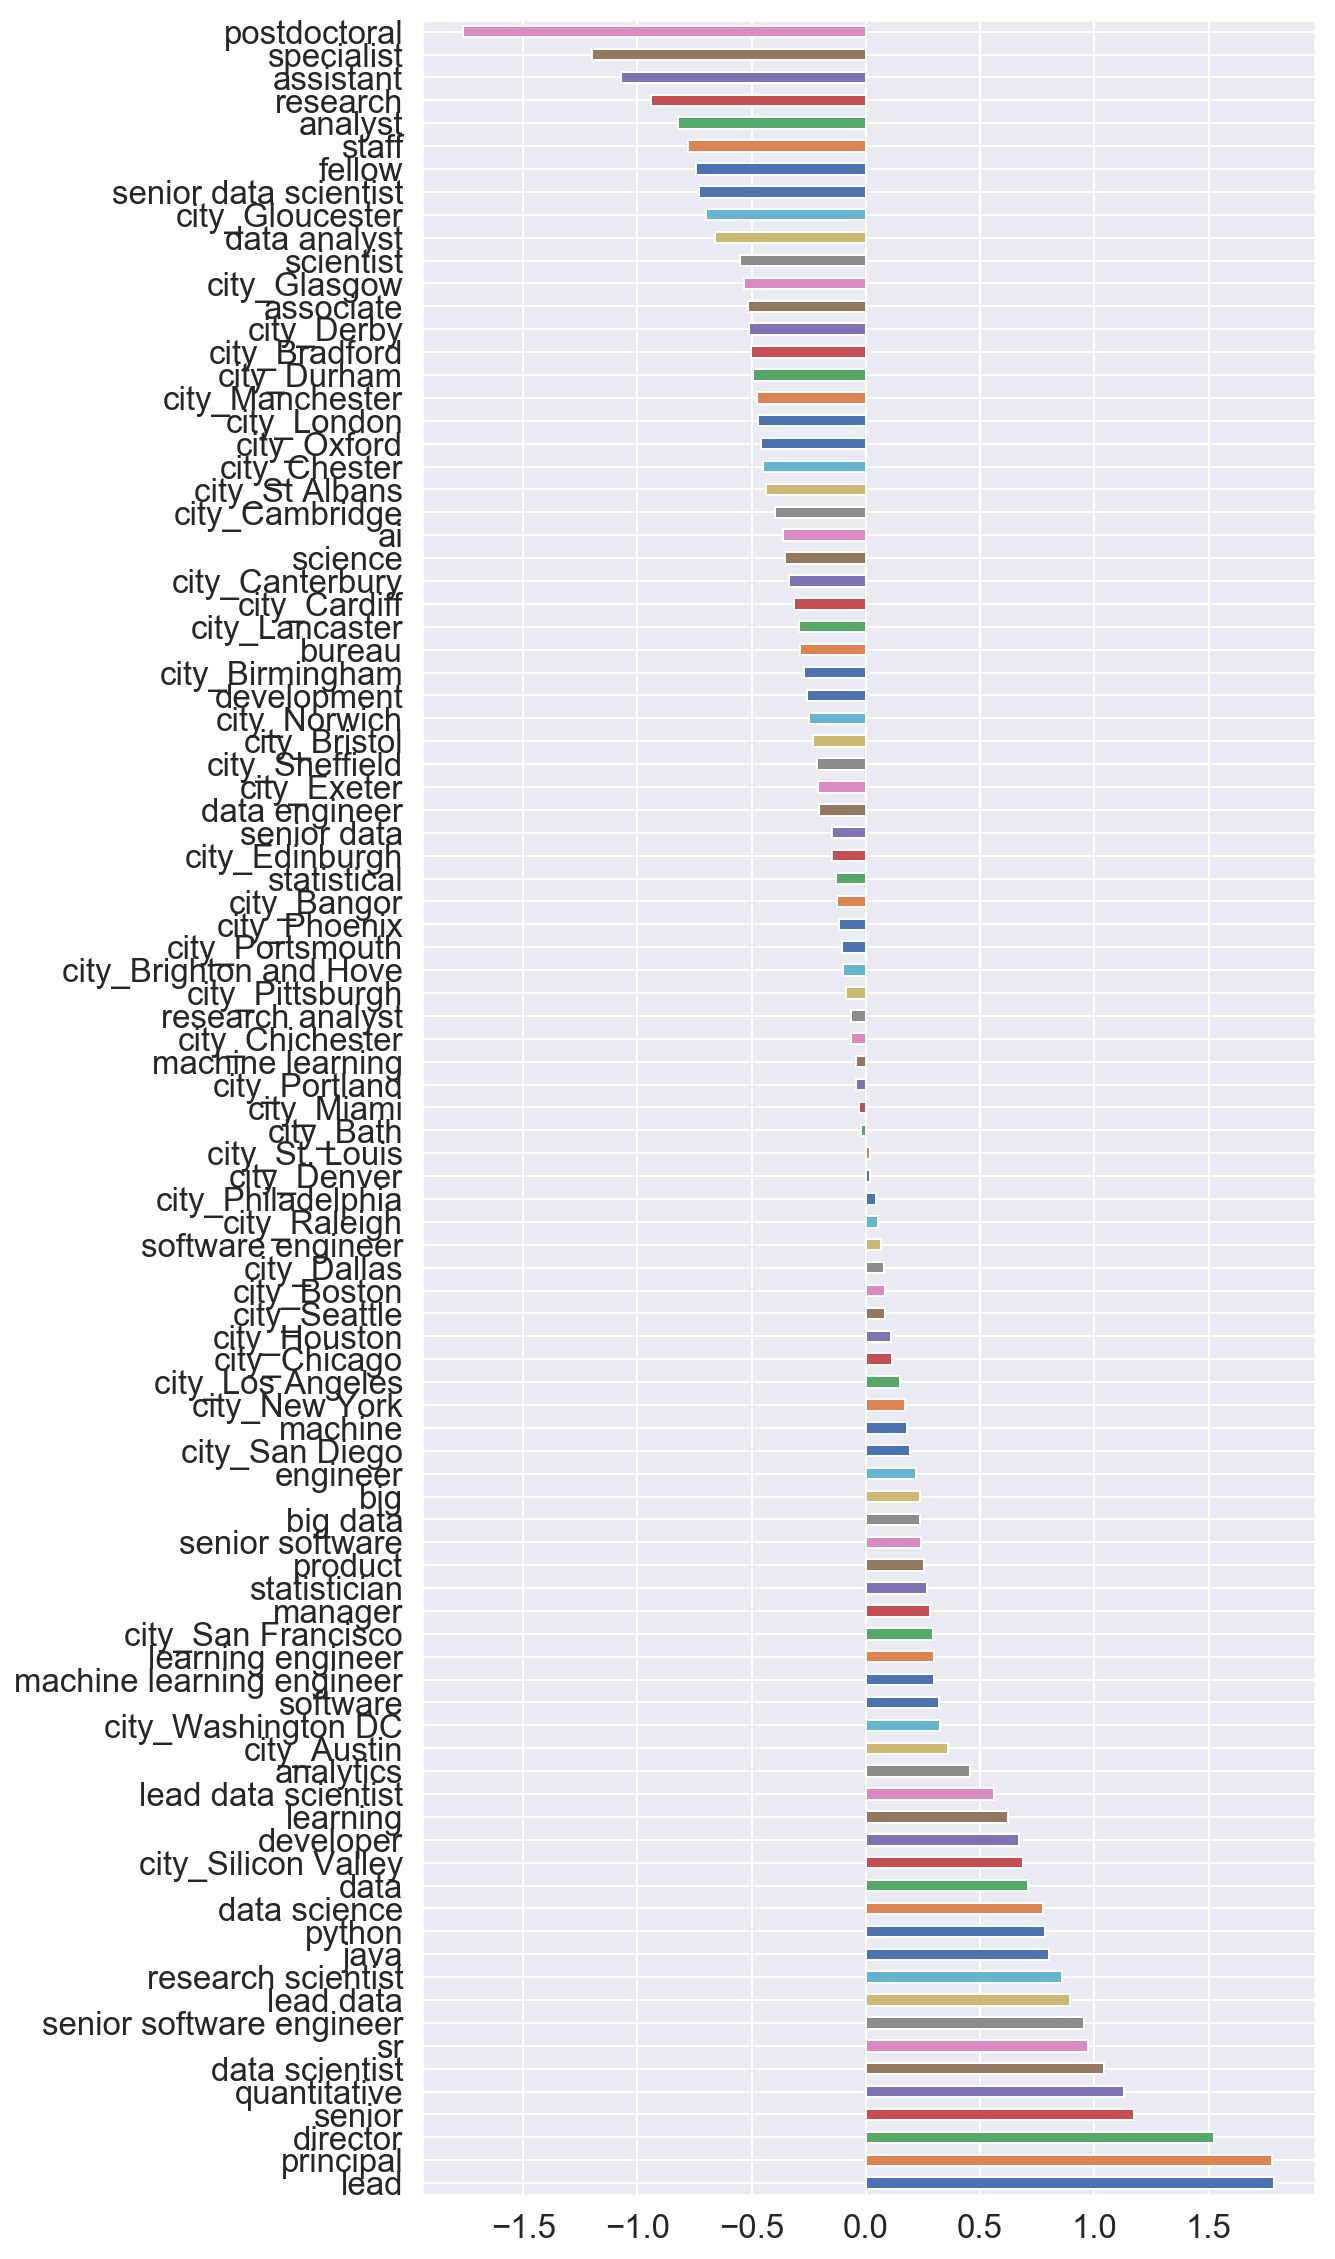

In [125]:
lrmodel_title=LogisticRegression()
logreg_full = fitter(lrmodel_title,X_train_full,y_train,X_test_full,y_test)
lrcoefs = pd.DataFrame(logreg_full.coef_,columns=X_train_full.columns,index=['Coefs']).T
lrcoefs['coef_abs']=abs(lrcoefs['Coefs'])
lrcoefs.sort_values(by='Coefs',ascending=False,inplace=True)
lrcoefs.plot(y='Coefs',kind='barh',figsize=(8,20),legend=False);

In [126]:
gs_params = {'C':np.logspace(-5,0,20),
            'penalty':['l1','l2']}
model=LogisticRegression(solver='liblinear')

gs=GridSearchCV(model,gs_params,cv=5,n_jobs=-1)
lr_mod=fitter(gs, X_train_full, y_train, X_test_full, y_test)

Cross Validated traing scores: [0.77931034 0.73103448 0.74740484 0.78892734 0.75347222]
Mean Cross Validated traing scores: 0.7600298459478451

Model Training score: 	 0.7835408022130014
Model test score: 	 0.7568438003220612
 CONFUSION MATRIX
     0    1
0  239   72
1   79  231
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       311
           1       0.76      0.75      0.75       310

   micro avg       0.76      0.76      0.76       621
   macro avg       0.76      0.76      0.76       621
weighted avg       0.76      0.76      0.76       621



### I now want to try optimize the model for presision to show how this affects the predictions

In [142]:
gs_params = {'C':np.logspace(-5,0,20),
            'penalty':['l2']}
model=LogisticRegression(solver='liblinear')

gs=GridSearchCV(model,gs_params,cv=5,n_jobs=-1,scoring='precision')
lr_mod=fitter(gs, X_train_full, y_train, X_test_full, y_test)
lr_best = lr_mod.best_estimator_
lr_best.fit(X_train_full,y_train)

Cross Validated traing scores: [0.77931034 0.73103448 0.74740484 0.78892734 0.75347222]
Mean Cross Validated traing scores: 0.7600298459478451

Model Training score: 	 0.7900709219858156
Model test score: 	 0.7623762376237624
 CONFUSION MATRIX
     0    1
0  239   72
1   79  231
              precision    recall  f1-score   support

           0       0.75      0.77      0.76       311
           1       0.76      0.75      0.75       310

   micro avg       0.76      0.76      0.76       621
   macro avg       0.76      0.76      0.76       621
weighted avg       0.76      0.76      0.76       621



LogisticRegression(C=0.2976351441631319, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

**The above result shows there is no diference if optimised for scoring or precision. Accuracy stays the same**

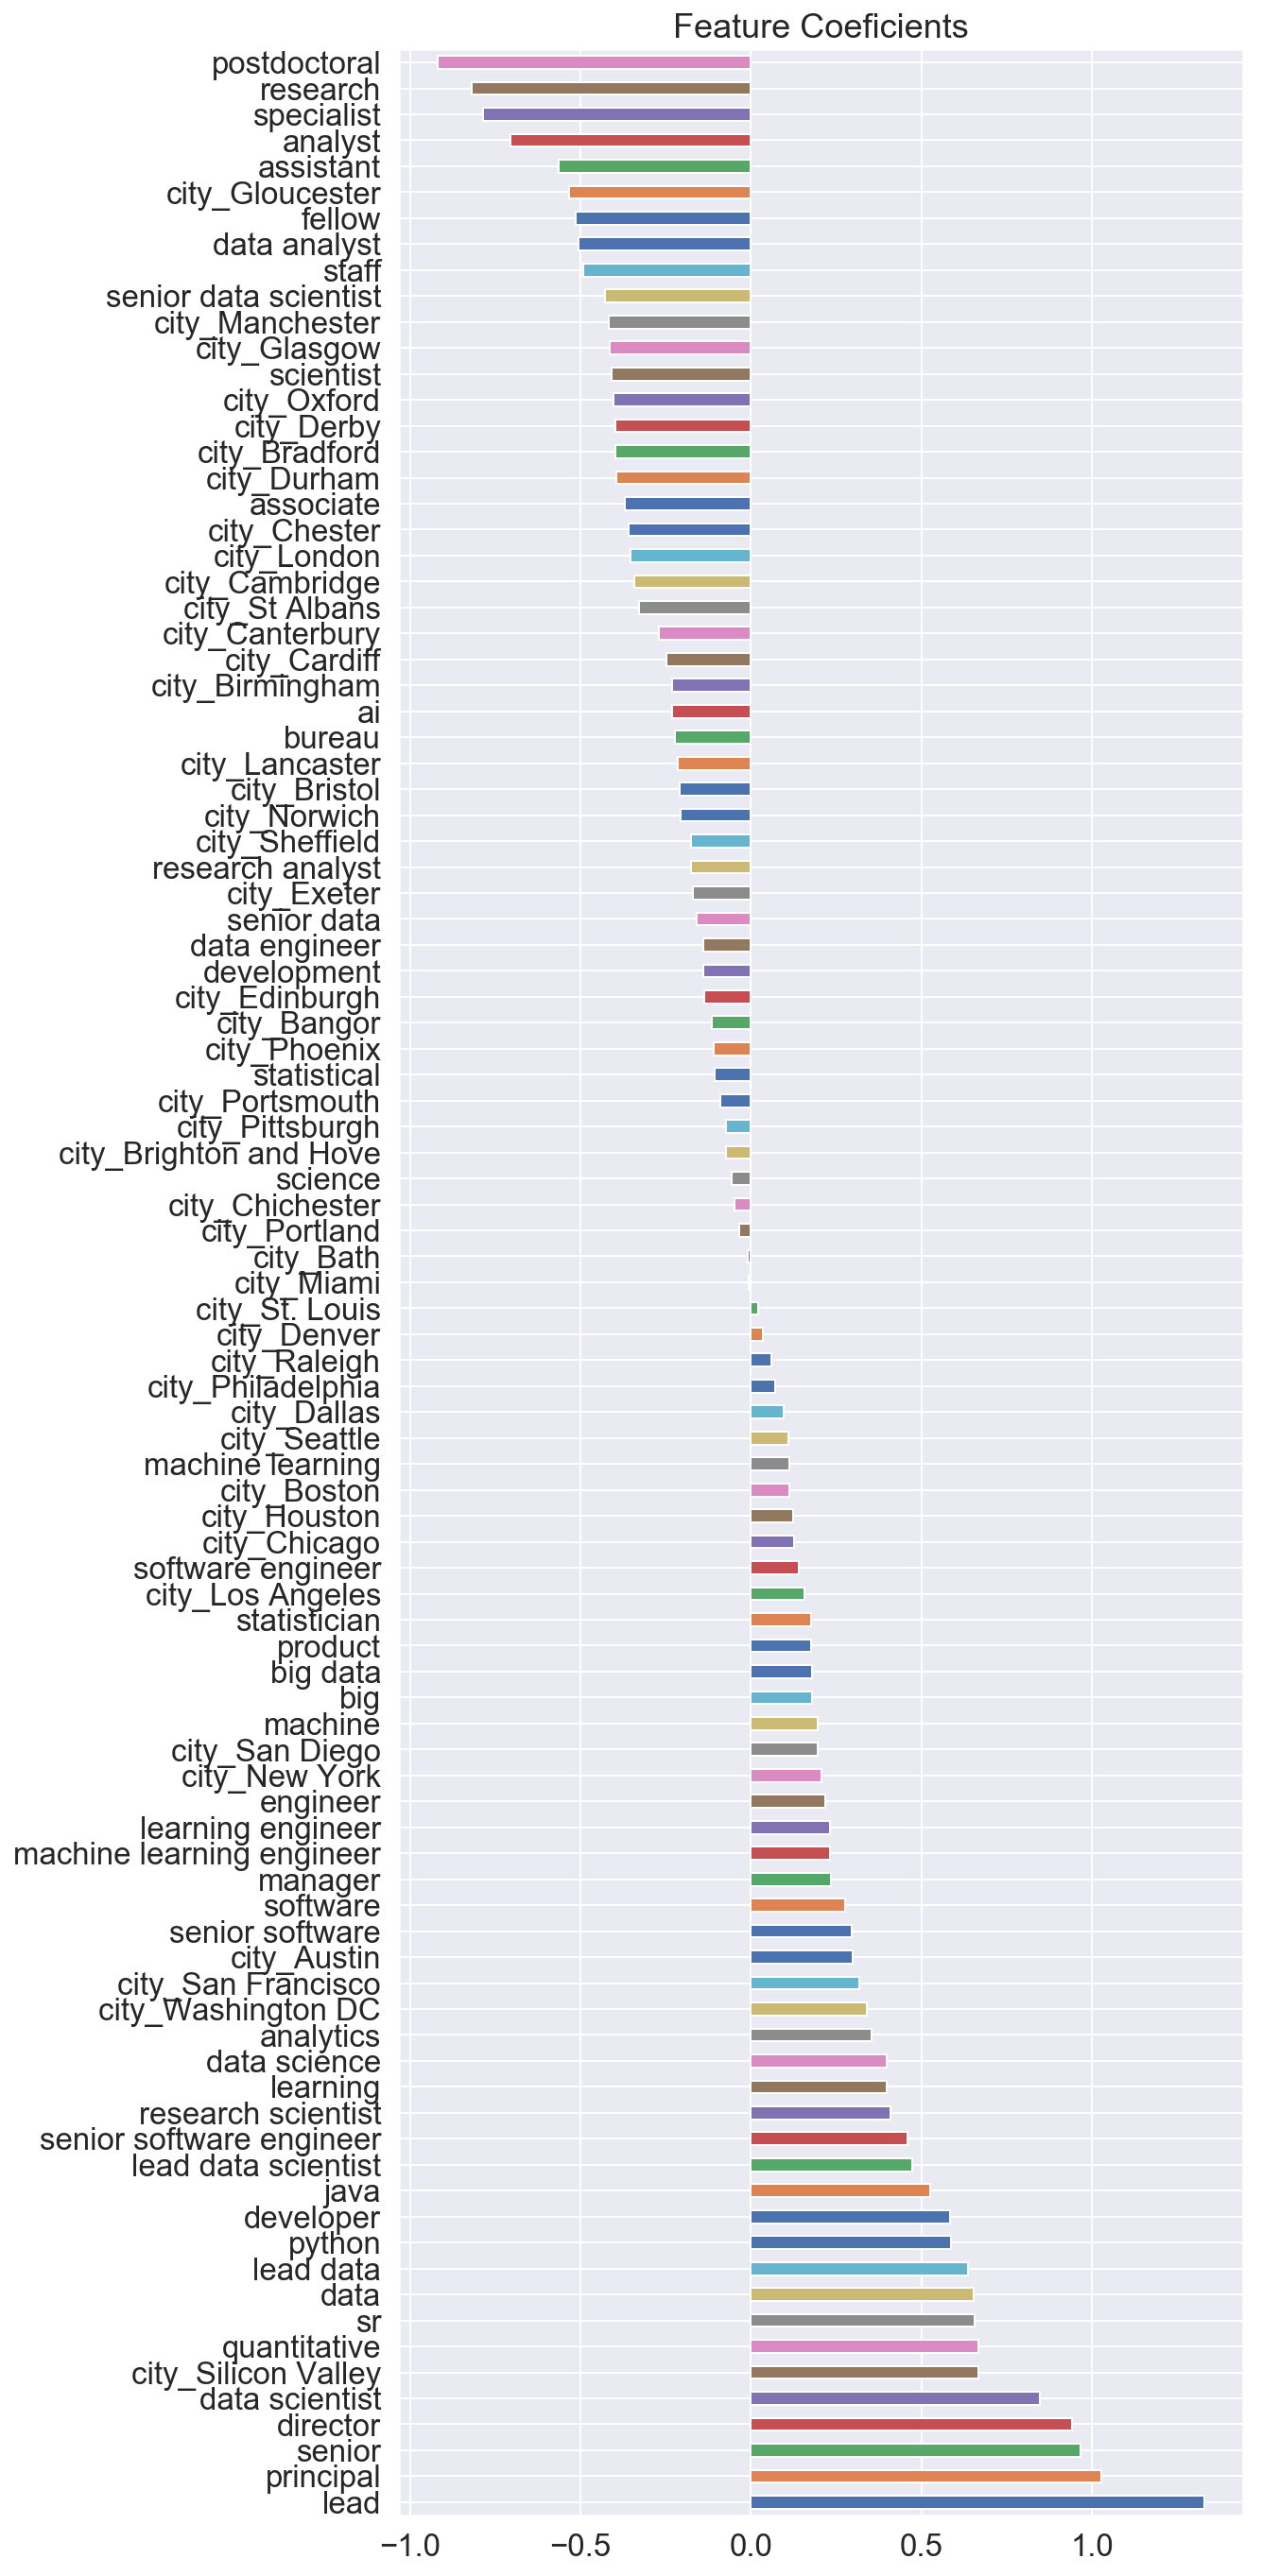

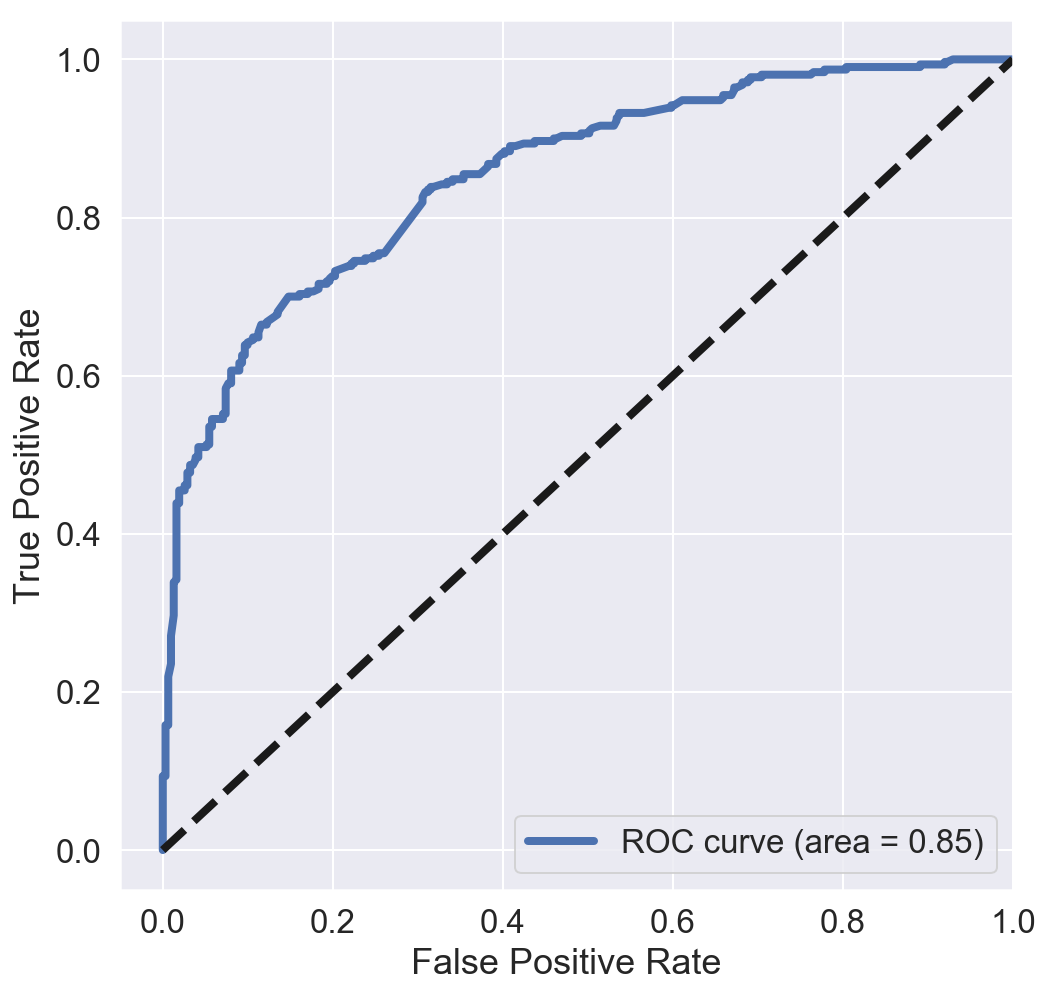

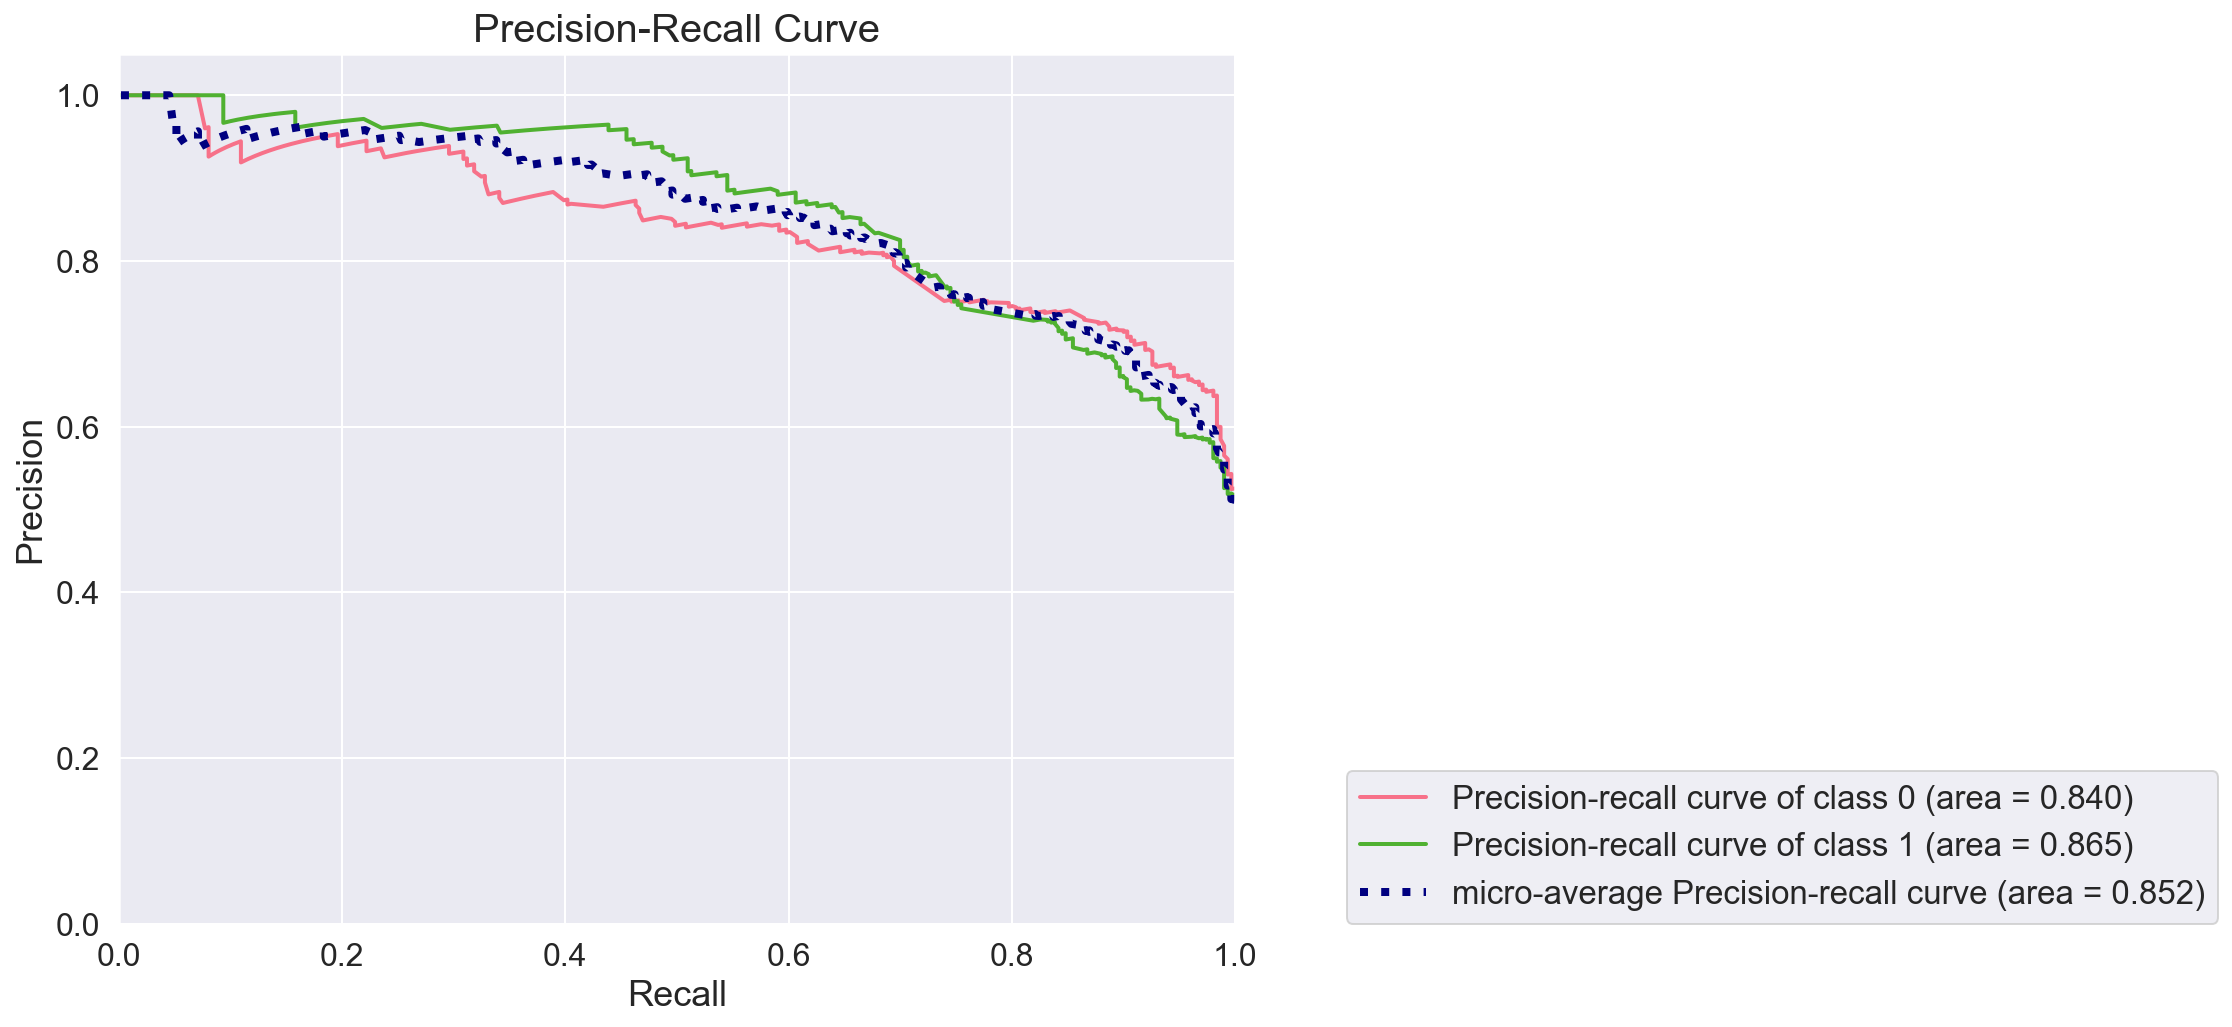

In [143]:
lrcoefs = pd.DataFrame(lr_best.coef_,columns=X_train_full.columns,index=['Coefs']).T
lrcoefs['coef_abs']=abs(lrcoefs['Coefs'])
lrcoefs.sort_values(by='Coefs',ascending=False,inplace=True)
lrcoefs.plot(y='Coefs',kind='barh',figsize=(8,24),legend=False,title='Feature Coeficients')
ROC_plotter(X_test_full,lr_best,y_test)
pr_plotter(X_test_full,y_test,lr_best)

**The model will now be adjusted to increse the threshold to the 75th percentile.**

In [153]:
y_train_75=X_train_safe.pop('sal_thresh_70')
y_test_75 = X_test_safe.pop('sal_thresh_70')

KeyError: 'sal_thresh_70'

In [154]:
len(y_test_75)

621

Cross Validated traing scores: [0.84137931 0.8        0.82068966 0.81597222 0.86111111]
Mean Cross Validated traing scores: 0.8278304597701152

Model Training score: 	 0.7880794701986755
Model test score: 	 0.8
 CONFUSION MATRIX
     0   1
0  406  24
1   95  96
              precision    recall  f1-score   support

           0       0.81      0.94      0.87       430
           1       0.80      0.50      0.62       191

   micro avg       0.81      0.81      0.81       621
   macro avg       0.81      0.72      0.74       621
weighted avg       0.81      0.81      0.79       621



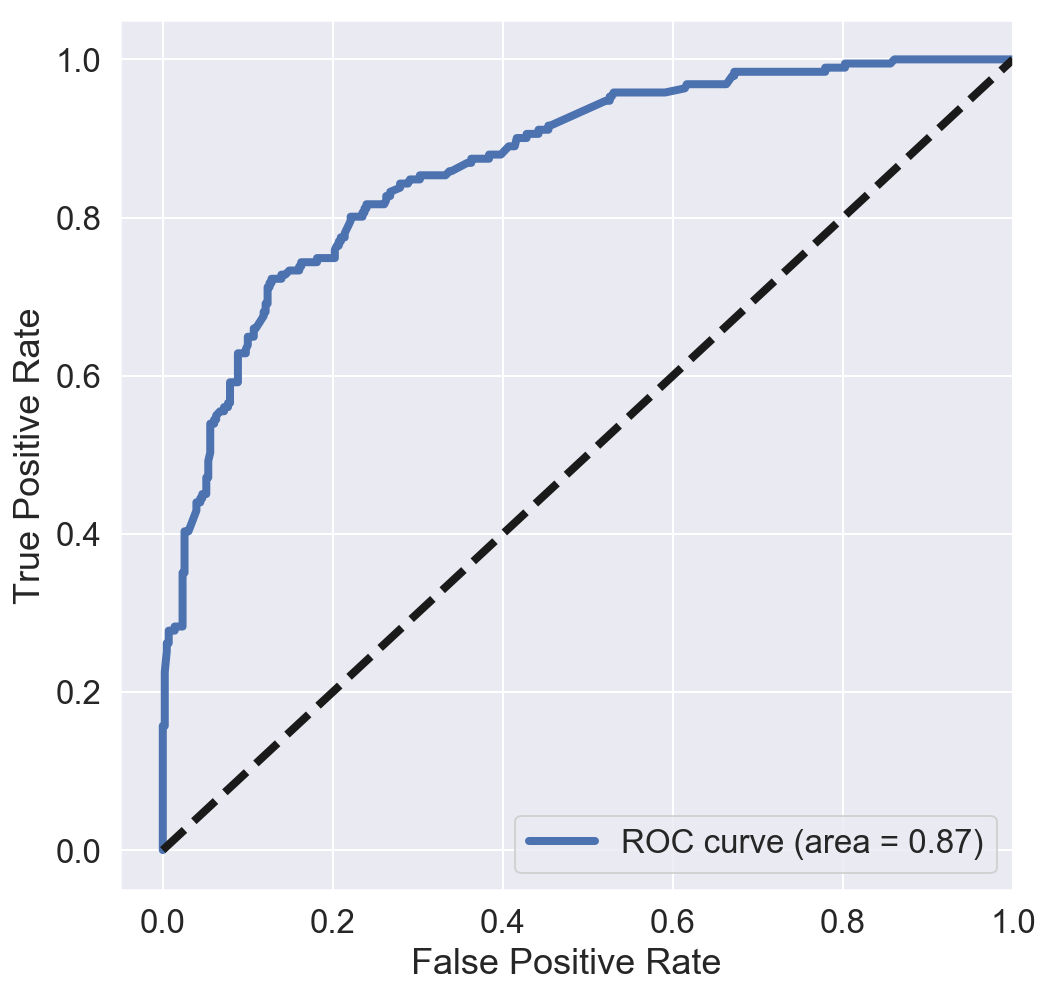

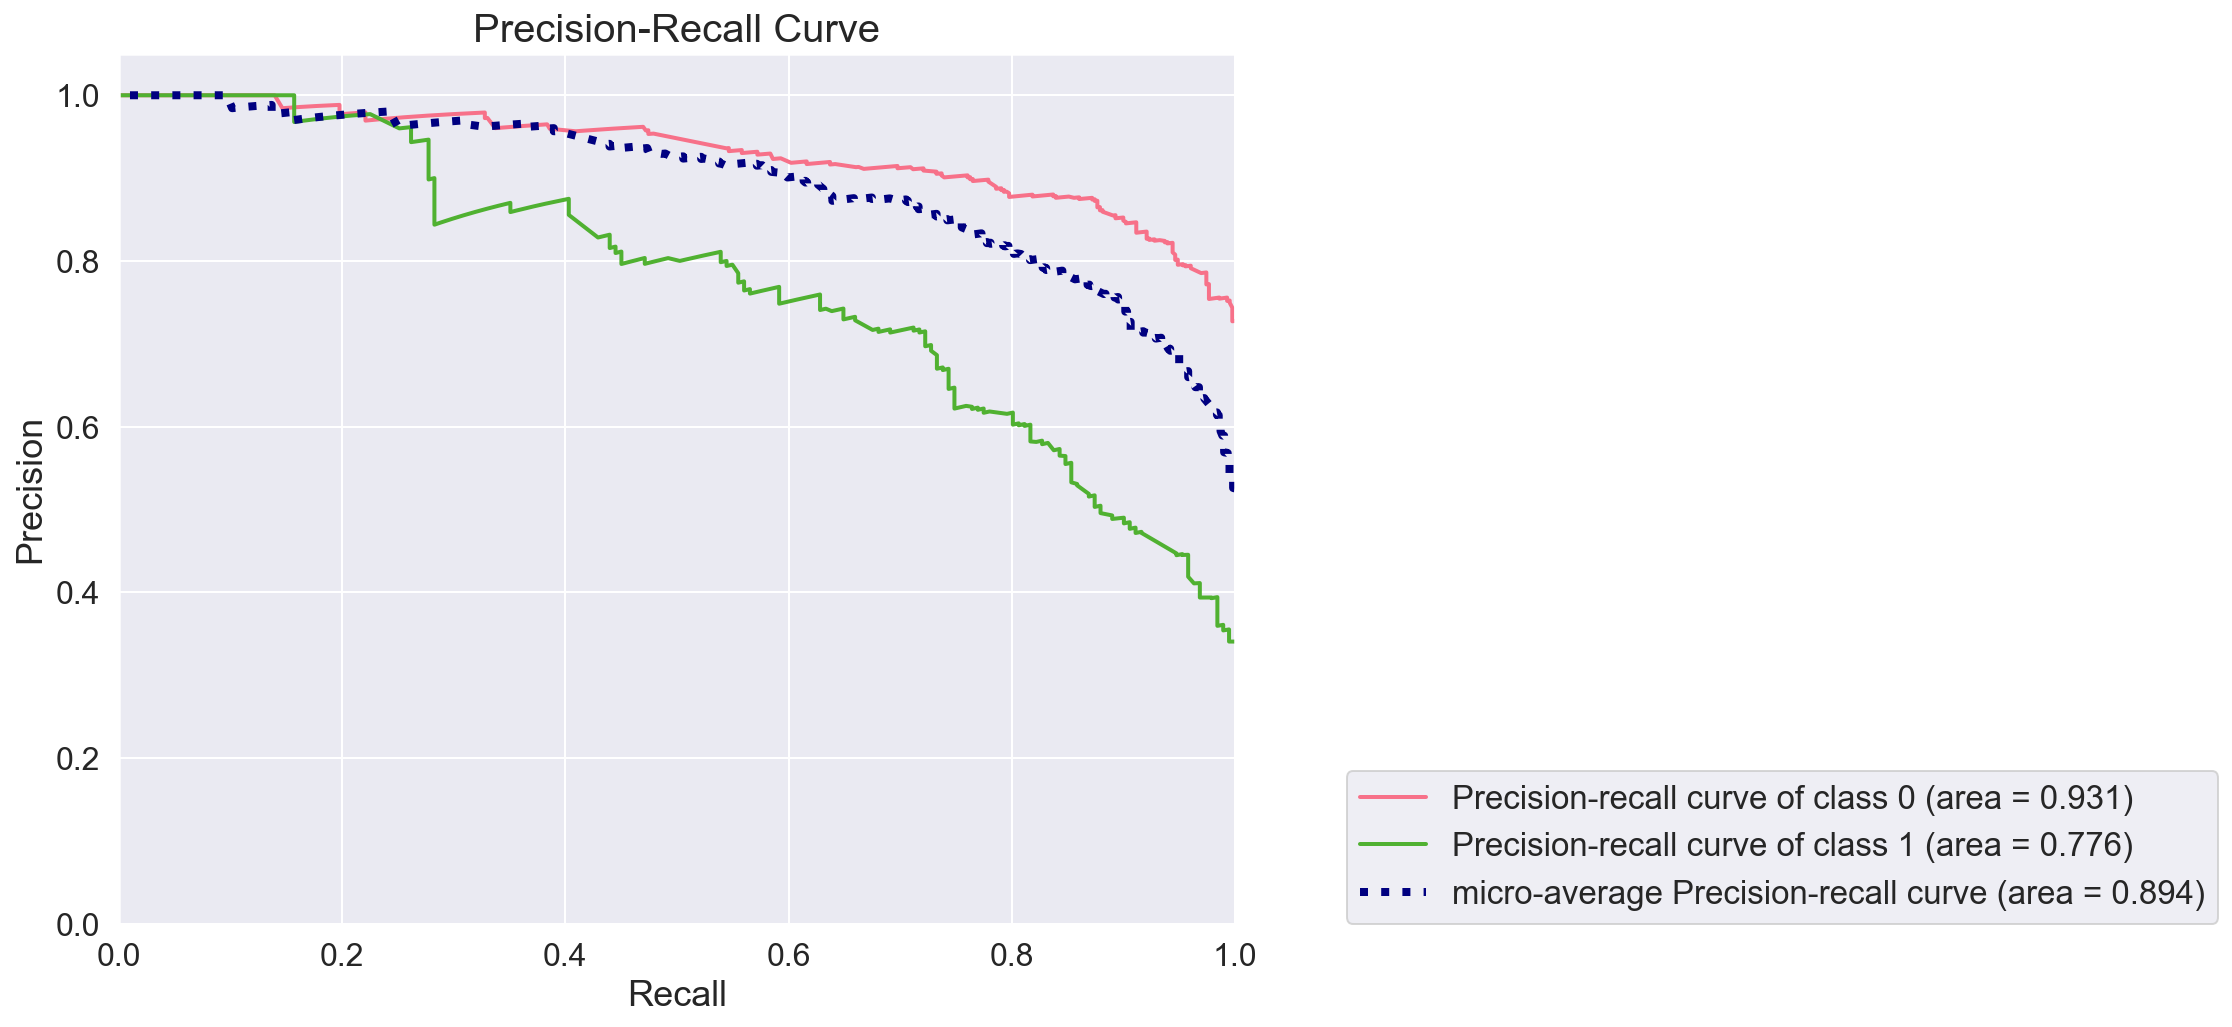

In [155]:
gs_params = {'C':np.logspace(-5,0,20),
            'penalty':['l2']}
model=LogisticRegression(solver='liblinear')

gs=GridSearchCV(model,gs_params,cv=5,n_jobs=-1,scoring='precision')
lr_mod=fitter(gs, X_train_full, y_train_75, X_test_full, y_test_75)
lr_best = lr_mod.best_estimator_
lr_best.fit(X_train_full,y_train_75)
ROC_plotter(X_test_full,lr_best,y_test_75)
pr_plotter(X_test_full,y_test_75,lr_best)

In [156]:
lr_best.score(X_test_full,y_test_75)

0.8083735909822867

This model shows that increasing the cut off threshold for the salary to 70% increases the presision and accuracy of the model, howevever this is simply because more jobs will be classified as low. the baseline for this model is 0.7, so in fact this model is actually only predicting 0.11 above the baseline, compared to 0.24 above baseline for the model using the median salary as the threshold.

While this model does give better presision with only 24 jobs wrongly predicted as high salary, almost half the high paying jobs will be classified as low paying (93 false negative vs 97 true negative). this is indicated by the low recall of 0.51.

The precision recall plot shows that the precision of high salary (class 1) drops off steadily as recall increases, however the precision of low salaries stays above 0.9 untill recall is above 0.8, indicating that it is not as sensitive to the threshold change.

## Try an ADABOOST desision tree classifier

In [157]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

0.9163208852005532
0.7517660647761472
0.7520128824476651
0.7520128824476651


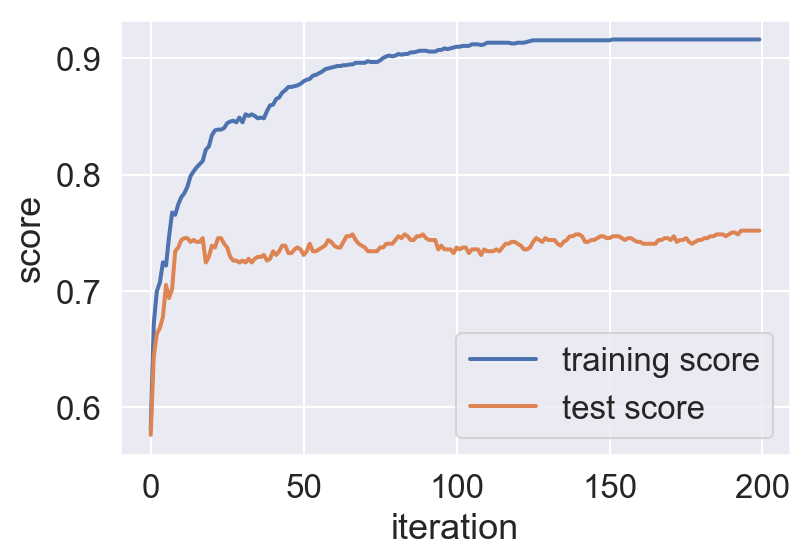

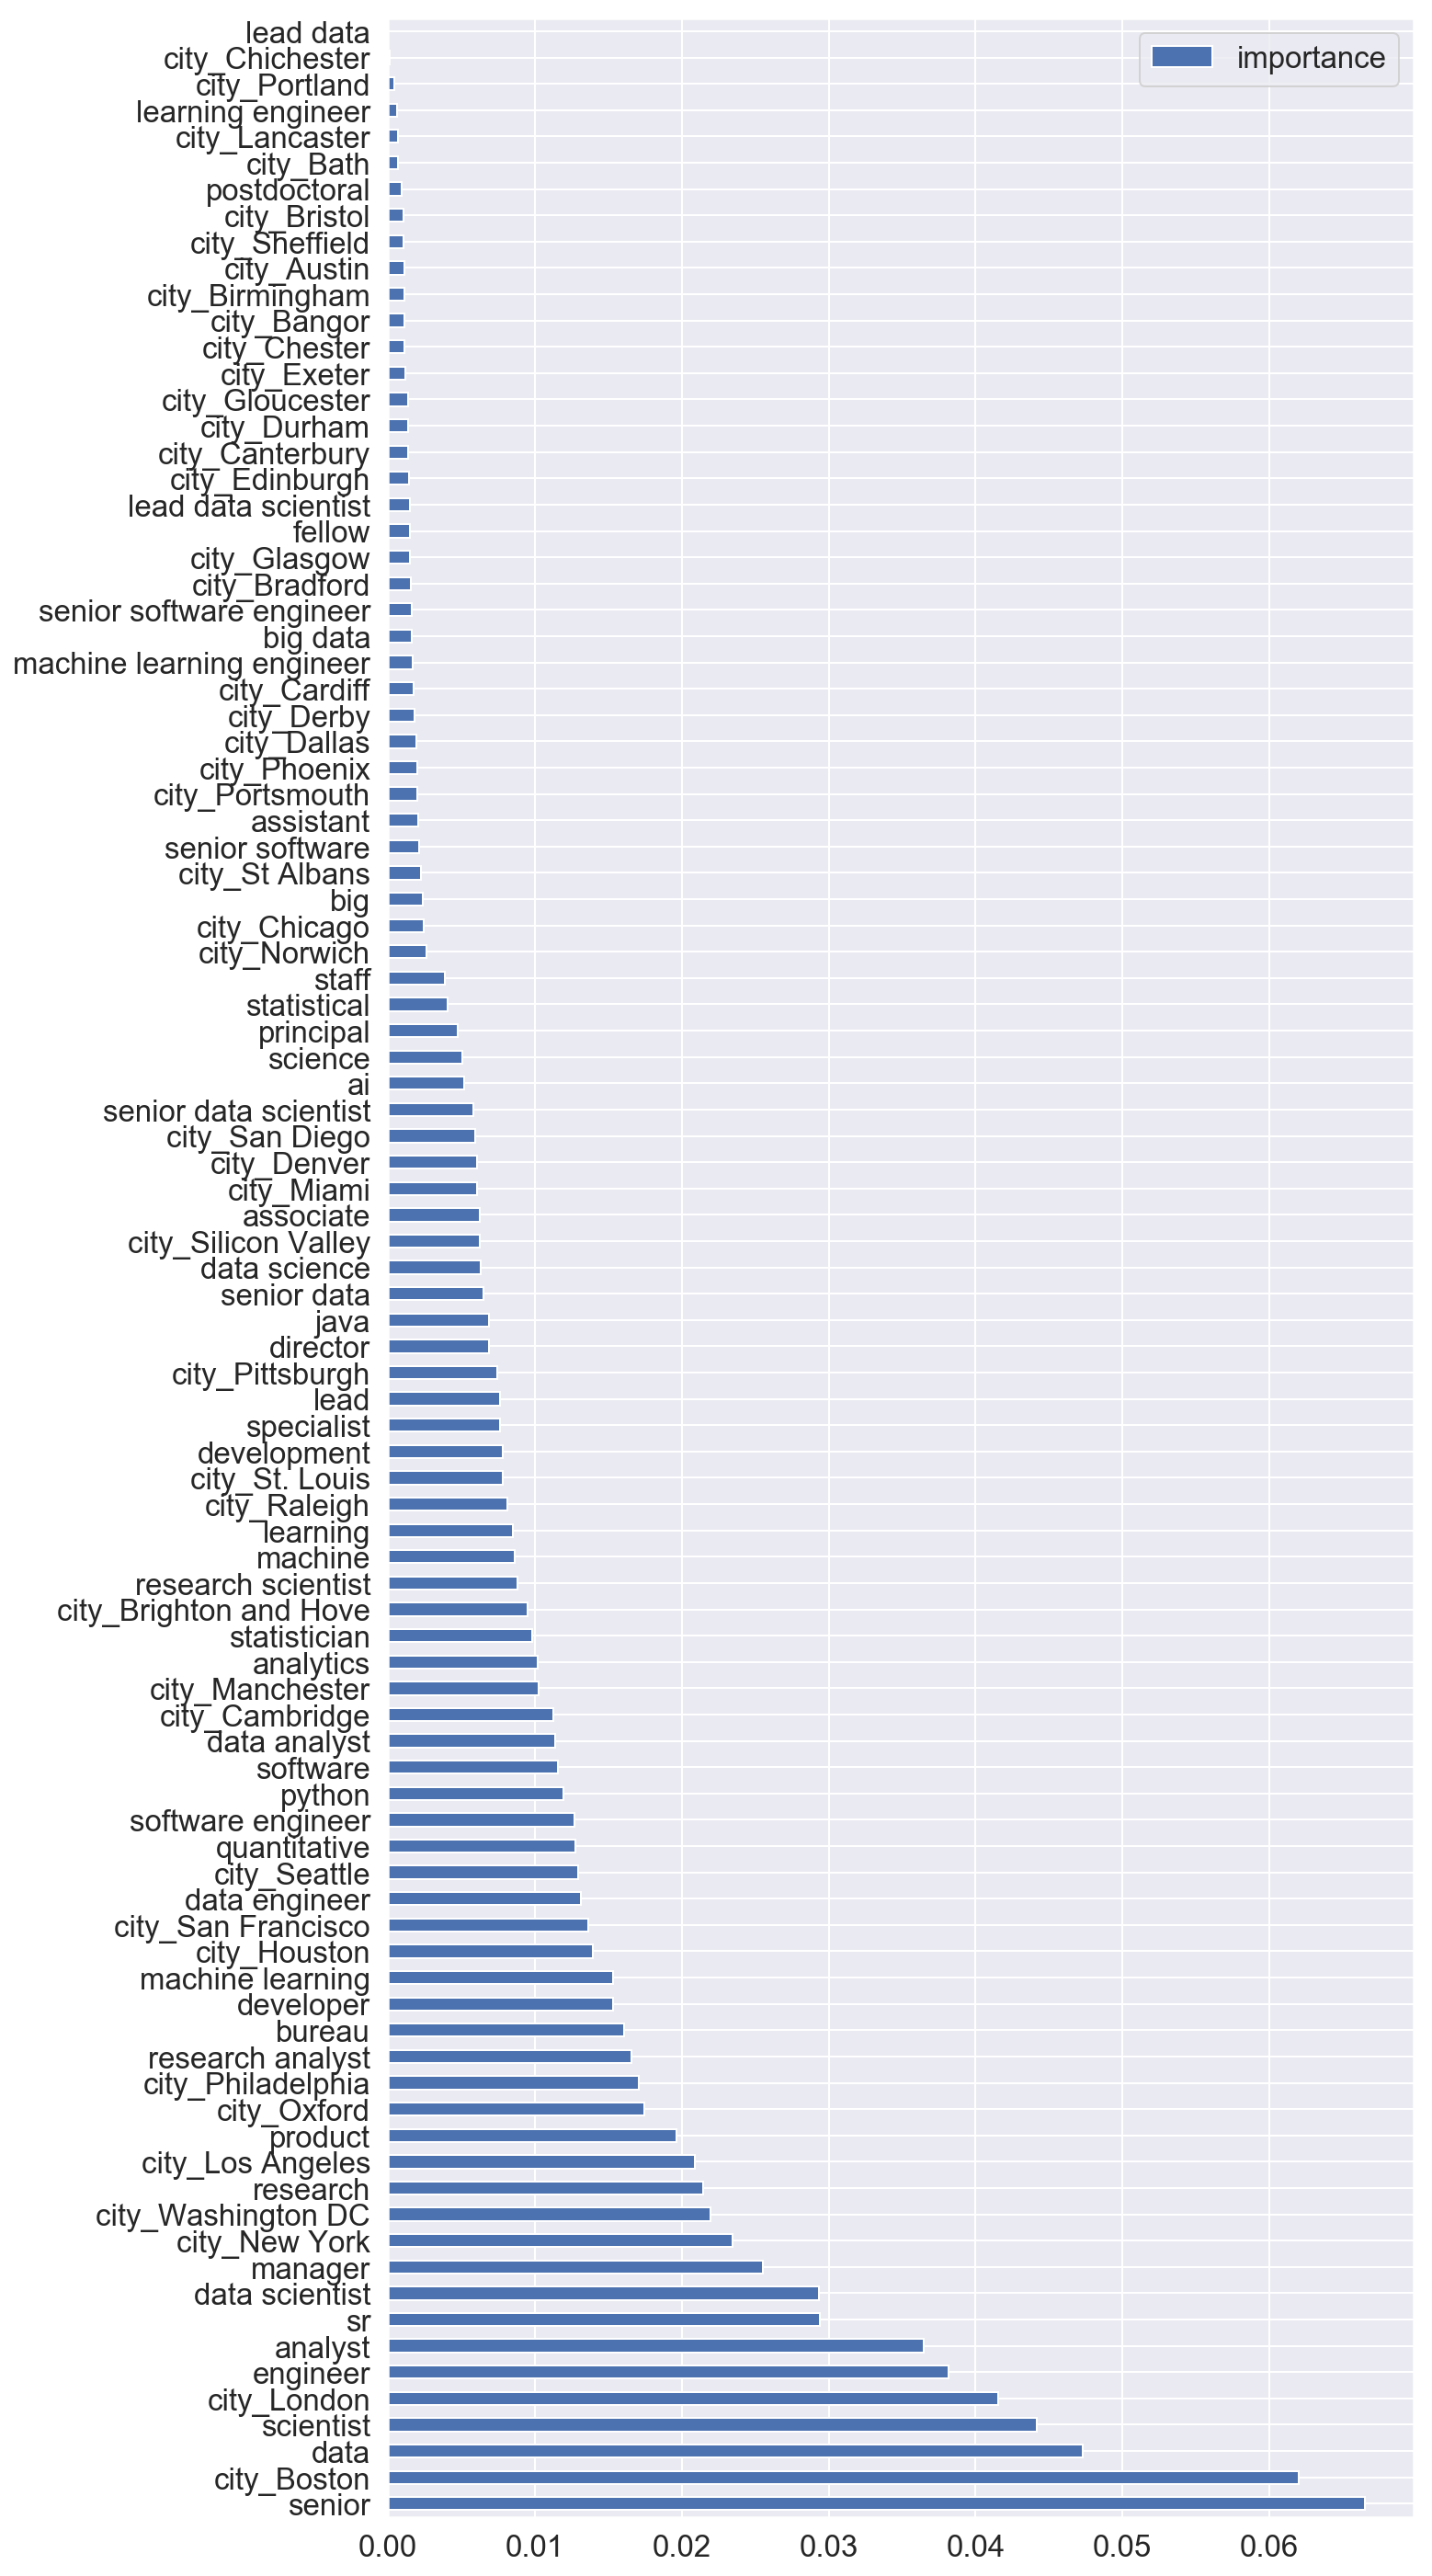

In [158]:
X_train = X_train_full.copy()
X_test = X_test_full.copy()

base_estimator = DecisionTreeClassifier(max_depth=3)
model = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=200, random_state=1,)
model.fit(X_train, y_train)

print(model.score(X_train,y_train))
print(cross_val_score(model, X_train, y_train , cv=5).mean())
print(model.score(X_test, y_test))
print(pd.DataFrame(model.staged_predict(X_test)).T.apply(lambda x: accuracy_score(y_test, x), axis=0)[model.n_estimators-1])

plt.plot(list(model.staged_score(X_train, y_train)), label='training score', lw=2)
plt.plot(list(model.staged_score(X_test, y_test)), label ='test score', lw=2)
plt.xlabel('iteration')
plt.ylabel('score')
plt.legend()
plt.show()

pd.DataFrame(model.feature_importances_,
             columns=['importance'], 
             index = X_train.columns
            ).sort_values(by='importance', ascending=False
            ).plot(kind='barh', figsize=(10,25));

**The accuracy score from the training model is less than the logistic regression model, and the test score is also lessthan the Logistic Regression. The logistic regression model provides the best results overall and should be the adopted model**

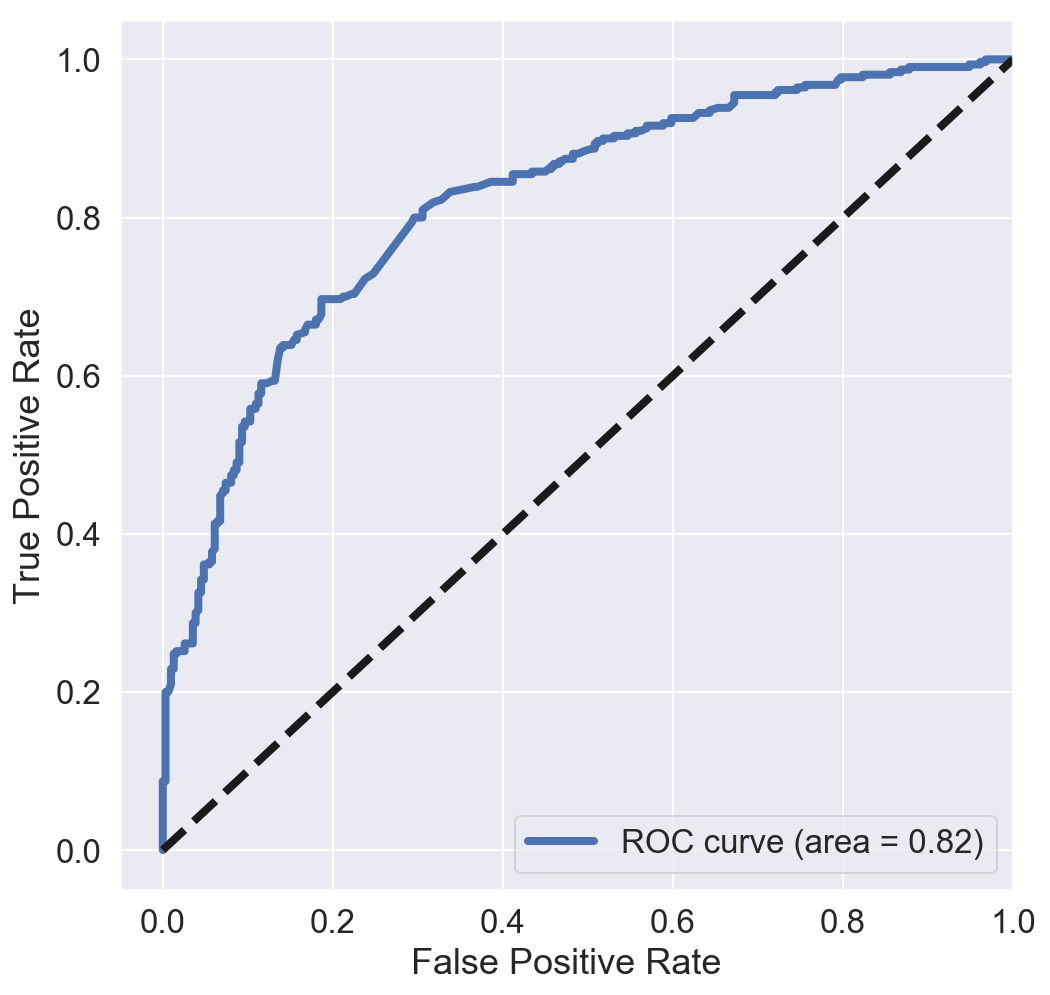

In [159]:
ROC_plotter(X_test_full,model,y_test)

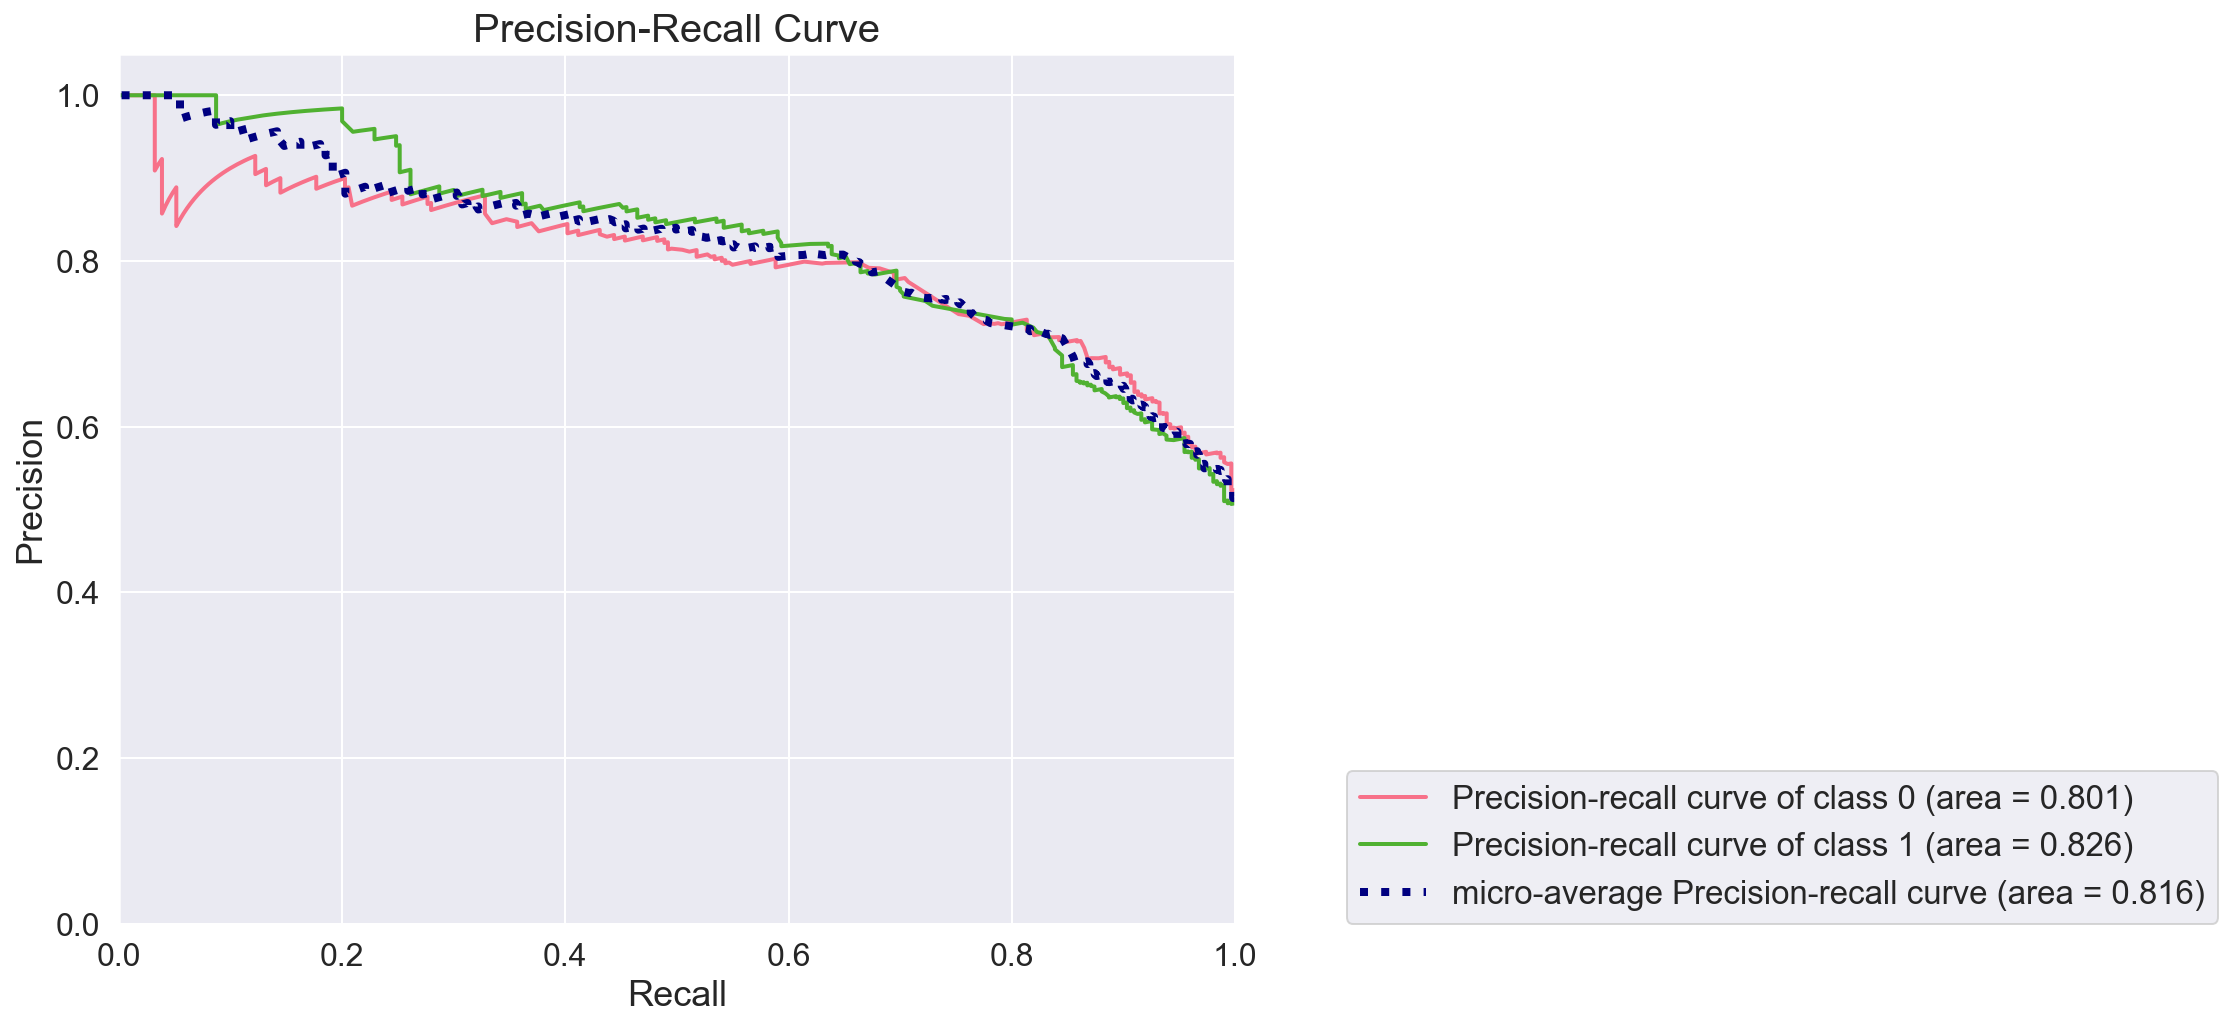

In [160]:
pr_plotter(X_test_full,y_test,model)

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

#### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

**Tradeoffs**

This Question is answered above with the explanation of the logistic regression model with a 75 percentile threshold. as presision increases, recall goes down and vis versa. as the threshold changes the accuracy stays the same.



### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

# Executive summary


#### Project Goals####

The aim of this project was to gather data on job postings from indeed.com and indeed.co.uk related to data science and make insights and predictions base on that information.  The hypothesis is that a jobs salary can be predicted high or low based on the job location and the job title.


#### Approach ####

- **Step-1 Data scrapping & Cleaning**

Posted Jobs information was scrapped from the indeed.com and indeed.co.uk websites for 90 cities using the search term “Data scientist” using *Beautiful soup*. This information was stored in a data frame for later use. Jobs with missing information were dropped, as well as any job post without a *yearly* salary. Cities with less than 5 job postings were excluded. In total 2067 clean jobs were recorded.

- **Step-2 feature selection**

Initial predictive models using only *job location* were used to determine the probability of a job having a salary above or below the median salary. The job titles were then count-vectorized using a ‘bag of words’ by encoding words as 1 if present and zero if not. The top 50 words/word combinations were used to see if there was a relationship between job title and salary. Models using both job title and location where created to combine the effects of both sets of features.

- **Step-3 Model development**

The scrapped data was split into a training and a test set. The test set size included 30 percent of the data and was shuffled and stratified so that the same proportion of high and low salaries were included in each set.

The training set was used to train the model and determine the coefficients /feature importance’s. Cross validated scoring ensured the models were not over fit to the data and would generalize well. The model was then scored using the test set to obtain final model predictions. 

- **Step-4 Model testing & refinement**

Once the best final model had been determined based on accuracy, the model was then refined by increasing the high/low threshold to the 70percentile, to lower the occurrence of false positives thereby increase the precision for predicting a high salary. Scoring was also optimised for precision.


#### Results ####

The highest accuracy score was achieved using a Logistic regression model using job title and location as predictors. The model predicted the correct salary classification (high/low) 74.9% of the time for the training data which was cross-validated to check generalisation, and 74.7% of the time on the test data. The baseline accuracy for the model is 50% so the model predicts correctly 25% better than just predicting a low salary. The precision and recall for this model were 0.75 for both.

#### Best estimator
_______________________________
Estimator : LogisticRegression

C (L2 penalty)=0.5455

Mean Cross Validated traing scores: 0.7496886973180076

Model Training score: 	 0.7904564315352697

Model test score: 	 0.7471819645732689
___________________________
 
 #### CONFUSION MATRIX

| act\pred | low | high |
| --- | --- | --- |
| low | 231 | 80 |
| high | 77 | 233 |

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       311
           1       0.74      0.75      0.75       310
_____________________________

Based on this logistic regression model the top 6 predictors for a high salary are :
- city_Silicon Valley
- data scientist
- director
- senior
- principal
- lead

And the top 6 predictors for a low salary are: 

- postdoctoral
- research
- specialist
- analyst
- assistant
- city_Gloucester
____________
#### Risks/Limitations####
Due to the data being collected from both the UK and the USA and only predicting if a salary is high or not makes this a simple model. It can be seen from exploratory data analysis that the majority of UK cities have a median salary less than the global median while most US cities have salaries higher than the median. This makes it hard to predict a high salary for any UK city, even if title keywords suggest a high salary, and vis versa for USA cities.
______________
#### Further Research####

One area for further analysis would be to look at the company and see if the company affects the salary. Perhaps being a private or public company such as a university or state department may also be a good predictor of salary.


<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [ ]:
## YOUR LINK HERE IN MARKDOWN FORMAT 